In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from cifar_model import generator,discriminator,cnn
import utils

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
'''
build unl data pipeline 
train gan cifar10 kinglsey
generate adv pert
train takeru or simple cnn cifar
get gains !
'''

'\nbuild unl data pipeline \ntrain gan cifar10 kinglsey\ngenerate adv pert\ntrain takeru or simple cnn cifar\nget gains !\n'

In [3]:
params = dict(
    batch_size = 50,
    seed = 1234,
    z_dim = 100,
    lr = 1e-4,
    logdir = 'cifar_gans/',
    name_model = 'model_kingsley'
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [4]:
params_dnn = dict(
    batch=50,
    lr = 1e-4,
    labeled = 100,
    seed = 1234,
    epoch=401
)

In [5]:
def plot_dics(l):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    names=[]
    for var in ['train','test','ema']:
        for d in l:
            x=d.item().get(var)
            plt.plot(x)
            names.append(var + '_' + d.item().get('name'))
    plt.legend(names)
    plt.subplot(122)
    names=[]
    for var in ['loss','mani']:
        for d in l:
            x=d.item().get(var)
            plt.plot(x)
            names.append(var + '_' + d.item().get('name'))
            plt.legend(names)

## Data

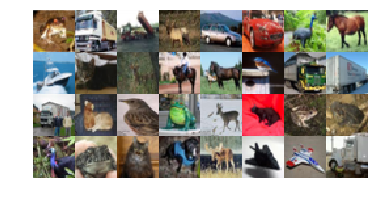

In [6]:
(trainx, trainy), (testx, testy) = tf.keras.datasets.cifar10.load_data()
def rescale(mat):
    return ((-127.5 + mat) / 127.5)
trainx = rescale(trainx)
testx = rescale(testx)
trainy = np.squeeze(trainy)
testy = np.squeeze(testy)
trainx_unl = trainx.copy()
nr_batch_unl = trainx_unl.shape[0] // params['batch_size']
utils.show_cifar(trainx_unl[:32])

train: (1000, 32, 32, 3) test: (10000, 32, 32, 3)


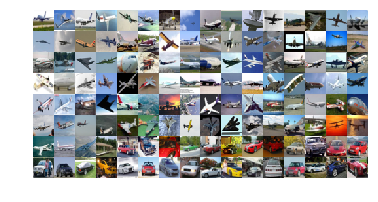

In [7]:
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys
nr_batch_train = trainx.shape[0] // params_dnn['batch']
nr_batch_test = testx.shape[0] // params_dnn['batch']
print('train:',trainx.shape,'test:',testx.shape)
utils.show_cifar(trainx[:128])

## GAN training

In [8]:
unl = tf.placeholder(tf.float32, [params['batch_size'], 32,32,3])
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(unl,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5)

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer.minimize(loss_d,var_list=disc_vars)

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [10]:
saver = tf.train.Saver()

In [11]:
path = './gan_cifar_saved/'
if tf.train.latest_checkpoint(path) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(path))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_cifar_saved/kingsley


In [12]:
# viz_every = 500
# for epoch in tqdm(range(10001)):
#     trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
    
#     for step in range(nr_batch_unl):
#         ran_from = step * params['batch_size']
#         ran_to = (step + 1) * params['batch_size']
#         sess.run(traind,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})
#         sess.run(traing,{is_training_pl:True,unl:trainx_unl[ran_from:ran_to]})

#         if (step) % viz_every == 0:
#             xx, yy = sess.run([unl,samples],{is_training_pl:False,unl:trainx_unl[ran_from:ran_to]})
#             plt.figure(figsize=(15,5))
#             plt.subplot(121)
#             utils.show_cifar(xx[:32])
#             plt.subplot(122)
#             utils.show_cifar(yy[:32])
#             plt.show()


In [13]:
# saver.save(sess, './gan_cifar_saved/kingsley')

## Vizualization manifold examples

In [14]:
# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],32,32,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 20.* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3])


In [15]:
xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})
xx = (xx+1.)/2.
yy = (yy+1.)/2.
yy[yy>1.]=1
yy[yy<0]=0

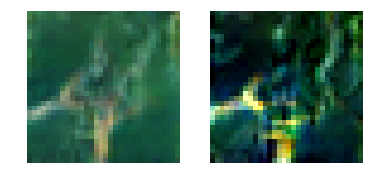

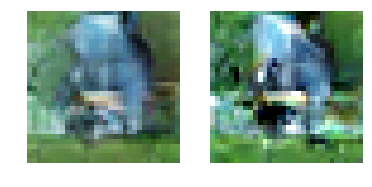

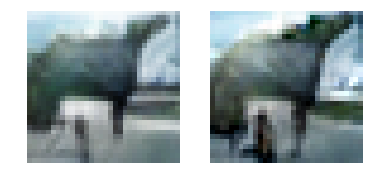

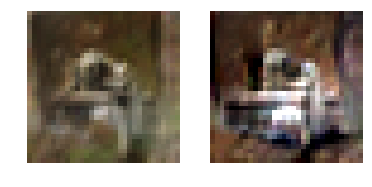

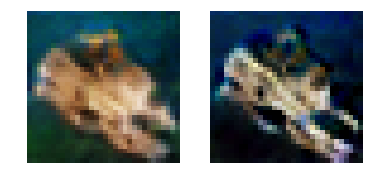

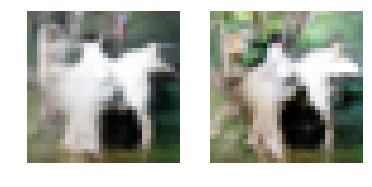

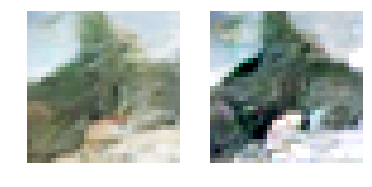

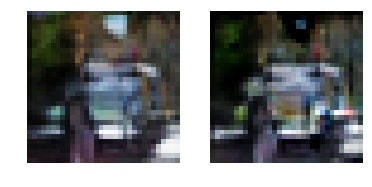

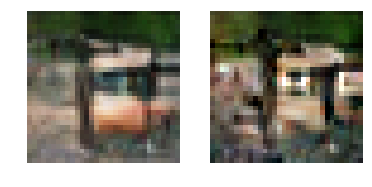

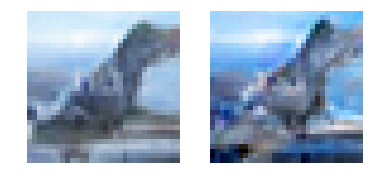

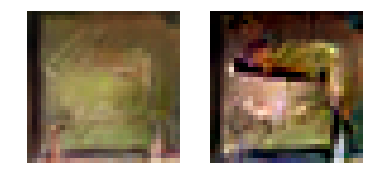

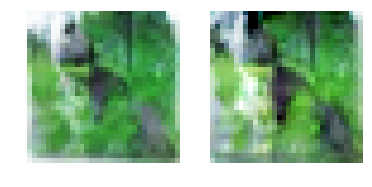

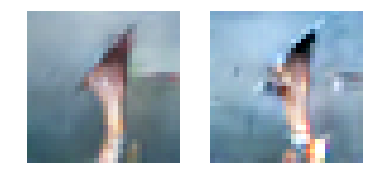

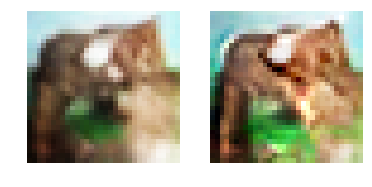

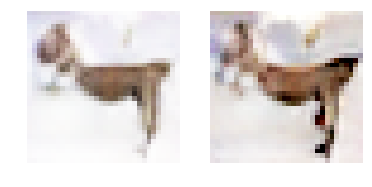

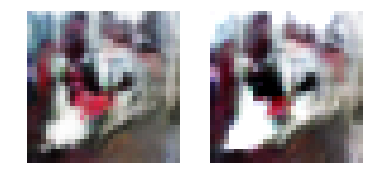

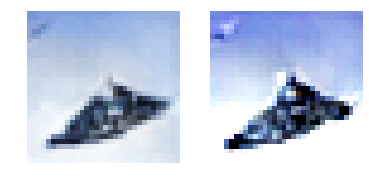

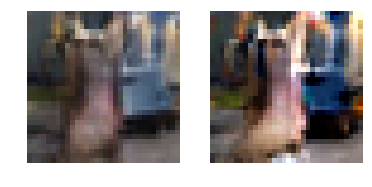

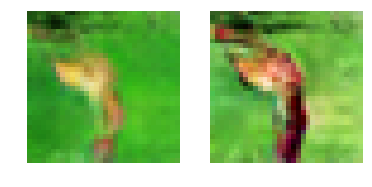

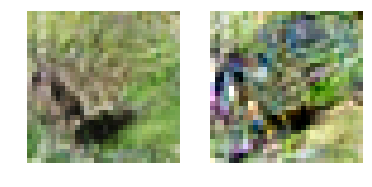

In [16]:
for idx in range(20):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]))
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]))
    plt.axis('off')
    plt.show()

## Training CNN

In [17]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 32,32,3])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
# ma_decay = tf.placeholder(tf.float32,[],name='ma_decay_pl')
training_cnn  = tf.placeholder(tf.bool,[])
logits = cnn(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [18]:
logits_z1= cnn(samp_z1,training_cnn)
logits_z2 = cnn(samp_z2+pz,training_cnn)
logits_adv = cnn(samp_adv,training_cnn) # ADD PZ 

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)

In [19]:
loss = xloss #+ 0.03 * manifold_loss

In [20]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    global_step = tf.Variable(0, name='global_step',trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS,scope='classifier')  # control dependencies for batch norm ops
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'),global_step=global_step)
        
correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:
ema = tf.train.ExponentialMovingAverage(decay=0.99)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='classifier')
maintain_averages_op = ema.apply(dvars)

with tf.control_dependencies([train_op]):
    train_op = tf.group(maintain_averages_op)

def ema_getter(getter, name, *args, **kwargs):
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var 
    
logits_ema = cnn(inp, training_cnn, getter=ema_getter)
correct_prediction_ema = tf.equal(tf.argmax(logits_ema,1),lbl)
accuracy_ema = tf.reduce_mean(tf.cast(correct_prediction_ema, tf.float32))

In [22]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [23]:
sess.run(init_op)
name_experiment = 'vanilla_ema2.npy'
train_array = [];test_array=[]; loss_array=[]; manifold_array=[];test_array_ema=[]

Epoch: 0,global_stp: 20, xloss: 2.25980, maniloss: 2.11578, train: 15.20%, test: 10.00,test_ma: 10.00%


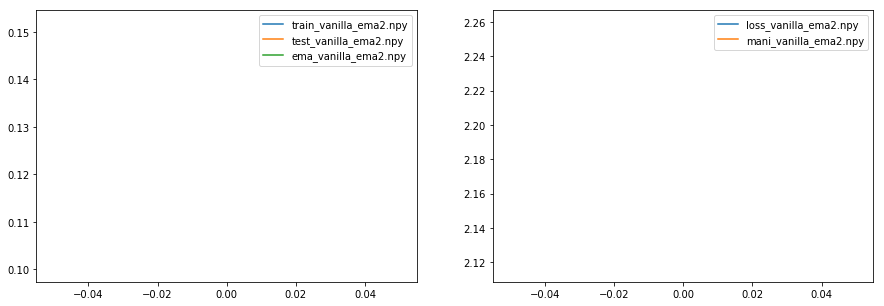

Epoch: 1,global_stp: 40, xloss: 2.06097, maniloss: 2.86139, train: 26.20%, test: 10.12,test_ma: 9.97%
Epoch: 2,global_stp: 60, xloss: 1.94000, maniloss: 3.39198, train: 29.20%, test: 10.08,test_ma: 10.81%
Epoch: 3,global_stp: 80, xloss: 1.85209, maniloss: 3.71630, train: 34.00%, test: 11.74,test_ma: 10.46%
Epoch: 4,global_stp: 100, xloss: 1.79077, maniloss: 4.04943, train: 34.60%, test: 13.10,test_ma: 11.43%
Epoch: 5,global_stp: 120, xloss: 1.73677, maniloss: 4.28143, train: 38.50%, test: 16.55,test_ma: 11.82%
Epoch: 6,global_stp: 140, xloss: 1.67513, maniloss: 4.54814, train: 39.70%, test: 21.93,test_ma: 11.90%
Epoch: 7,global_stp: 160, xloss: 1.62327, maniloss: 4.57673, train: 42.60%, test: 23.91,test_ma: 12.57%
Epoch: 8,global_stp: 180, xloss: 1.58444, maniloss: 4.78638, train: 45.50%, test: 24.48,test_ma: 13.59%
Epoch: 9,global_stp: 200, xloss: 1.53527, maniloss: 5.15937, train: 47.10%, test: 25.64,test_ma: 14.65%
Epoch: 10,global_stp: 220, xloss: 1.49414, maniloss: 5.23982, train:

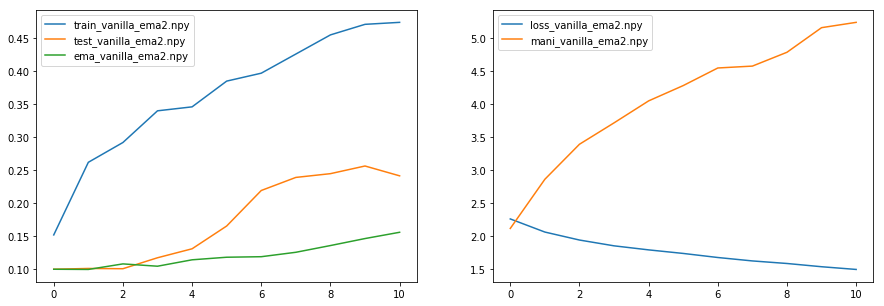

Epoch: 11,global_stp: 240, xloss: 1.44061, maniloss: 5.30620, train: 47.70%, test: 24.90,test_ma: 16.90%
Epoch: 12,global_stp: 260, xloss: 1.41988, maniloss: 5.54433, train: 50.20%, test: 24.68,test_ma: 17.46%
Epoch: 13,global_stp: 280, xloss: 1.39099, maniloss: 5.67572, train: 51.90%, test: 25.94,test_ma: 18.63%
Epoch: 14,global_stp: 300, xloss: 1.37491, maniloss: 5.75497, train: 53.80%, test: 27.09,test_ma: 20.43%
Epoch: 15,global_stp: 320, xloss: 1.35146, maniloss: 5.99482, train: 53.30%, test: 29.17,test_ma: 20.72%
Epoch: 16,global_stp: 340, xloss: 1.31801, maniloss: 6.07889, train: 54.10%, test: 26.87,test_ma: 21.55%
Epoch: 17,global_stp: 360, xloss: 1.29814, maniloss: 6.13510, train: 56.00%, test: 24.92,test_ma: 22.49%
Epoch: 18,global_stp: 380, xloss: 1.27405, maniloss: 6.20470, train: 56.20%, test: 27.12,test_ma: 23.60%
Epoch: 19,global_stp: 400, xloss: 1.23635, maniloss: 6.34561, train: 56.90%, test: 27.66,test_ma: 24.14%
Epoch: 20,global_stp: 420, xloss: 1.23418, maniloss: 6.

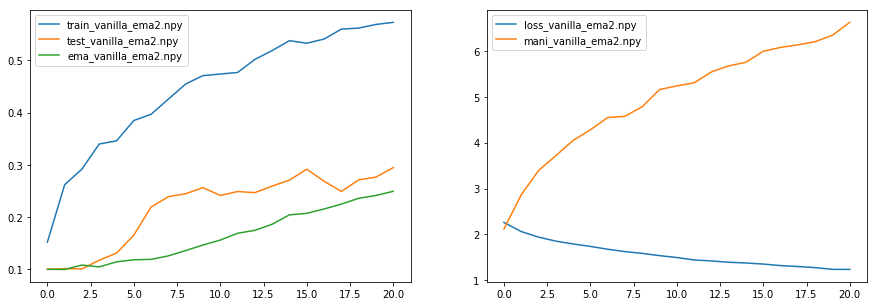

Epoch: 21,global_stp: 440, xloss: 1.17313, maniloss: 6.58109, train: 59.60%, test: 24.65,test_ma: 25.31%
Epoch: 22,global_stp: 460, xloss: 1.17330, maniloss: 6.90393, train: 60.40%, test: 26.81,test_ma: 25.42%
Epoch: 23,global_stp: 480, xloss: 1.15513, maniloss: 6.89127, train: 61.20%, test: 27.17,test_ma: 25.80%
Epoch: 24,global_stp: 500, xloss: 1.13306, maniloss: 6.97220, train: 60.90%, test: 30.15,test_ma: 26.15%
Epoch: 25,global_stp: 520, xloss: 1.11448, maniloss: 7.11265, train: 62.40%, test: 30.20,test_ma: 26.67%
Epoch: 26,global_stp: 540, xloss: 1.07980, maniloss: 7.16058, train: 63.80%, test: 34.81,test_ma: 26.34%
Epoch: 27,global_stp: 560, xloss: 1.04994, maniloss: 7.29631, train: 67.20%, test: 27.81,test_ma: 27.06%
Epoch: 28,global_stp: 580, xloss: 1.01216, maniloss: 7.40013, train: 67.90%, test: 30.53,test_ma: 27.21%
Epoch: 29,global_stp: 600, xloss: 1.04543, maniloss: 7.50291, train: 65.20%, test: 28.68,test_ma: 27.09%
Epoch: 30,global_stp: 620, xloss: 0.99932, maniloss: 7.

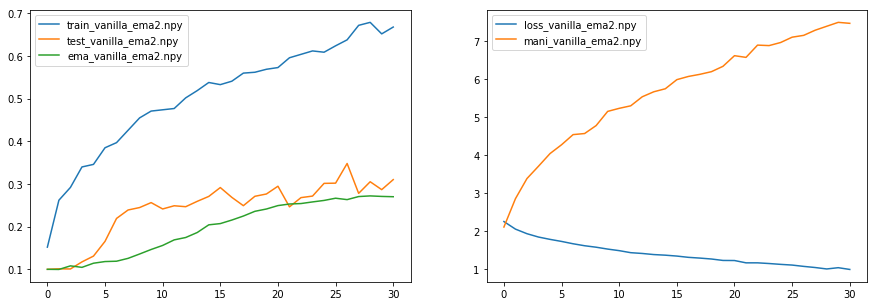

Epoch: 31,global_stp: 640, xloss: 0.95142, maniloss: 7.73495, train: 69.50%, test: 28.30,test_ma: 27.34%
Epoch: 32,global_stp: 660, xloss: 0.95256, maniloss: 7.72203, train: 68.50%, test: 30.38,test_ma: 27.45%
Epoch: 33,global_stp: 680, xloss: 0.95181, maniloss: 7.72894, train: 69.40%, test: 27.32,test_ma: 27.12%
Epoch: 34,global_stp: 700, xloss: 0.91994, maniloss: 8.06789, train: 69.70%, test: 30.23,test_ma: 27.61%
Epoch: 35,global_stp: 720, xloss: 0.89452, maniloss: 8.08457, train: 71.80%, test: 28.93,test_ma: 27.61%
Epoch: 36,global_stp: 740, xloss: 0.89668, maniloss: 8.07102, train: 70.10%, test: 30.20,test_ma: 27.86%
Epoch: 37,global_stp: 760, xloss: 0.87067, maniloss: 8.06199, train: 71.50%, test: 30.01,test_ma: 28.10%
Epoch: 38,global_stp: 780, xloss: 0.88890, maniloss: 8.17385, train: 70.90%, test: 27.37,test_ma: 28.30%
Epoch: 39,global_stp: 800, xloss: 0.84870, maniloss: 8.36175, train: 72.50%, test: 27.21,test_ma: 28.60%
Epoch: 40,global_stp: 820, xloss: 0.81711, maniloss: 8.

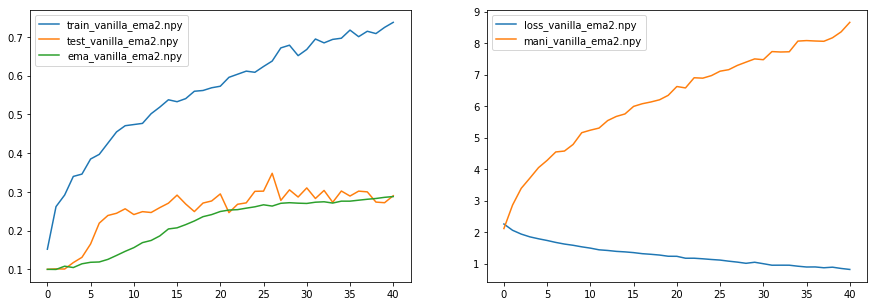

Epoch: 41,global_stp: 840, xloss: 0.81643, maniloss: 8.55941, train: 73.60%, test: 28.08,test_ma: 28.21%
Epoch: 42,global_stp: 860, xloss: 0.78886, maniloss: 8.44397, train: 72.90%, test: 29.67,test_ma: 28.63%
Epoch: 43,global_stp: 880, xloss: 0.78535, maniloss: 8.83637, train: 74.70%, test: 28.52,test_ma: 28.44%
Epoch: 44,global_stp: 900, xloss: 0.77890, maniloss: 8.65287, train: 76.40%, test: 28.41,test_ma: 29.36%
Epoch: 45,global_stp: 920, xloss: 0.76335, maniloss: 8.82074, train: 76.10%, test: 27.99,test_ma: 29.33%
Epoch: 46,global_stp: 940, xloss: 0.73457, maniloss: 8.96143, train: 76.50%, test: 29.11,test_ma: 29.54%
Epoch: 47,global_stp: 960, xloss: 0.70763, maniloss: 9.12319, train: 77.80%, test: 27.16,test_ma: 29.70%
Epoch: 48,global_stp: 980, xloss: 0.70880, maniloss: 9.11457, train: 78.00%, test: 28.43,test_ma: 29.39%
Epoch: 49,global_stp: 1000, xloss: 0.66040, maniloss: 8.96617, train: 79.00%, test: 29.46,test_ma: 29.12%
Epoch: 50,global_stp: 1020, xloss: 0.66923, maniloss: 

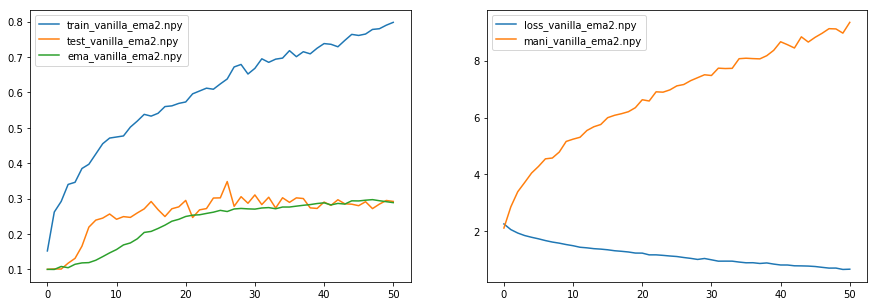

Epoch: 51,global_stp: 1040, xloss: 0.67193, maniloss: 9.08098, train: 79.90%, test: 25.97,test_ma: 29.25%
Epoch: 52,global_stp: 1060, xloss: 0.64928, maniloss: 9.39389, train: 80.30%, test: 28.12,test_ma: 28.62%
Epoch: 53,global_stp: 1080, xloss: 0.62014, maniloss: 9.45804, train: 80.80%, test: 28.03,test_ma: 29.20%
Epoch: 54,global_stp: 1100, xloss: 0.62252, maniloss: 9.57209, train: 80.70%, test: 28.01,test_ma: 29.27%
Epoch: 55,global_stp: 1120, xloss: 0.61347, maniloss: 9.57827, train: 81.20%, test: 32.63,test_ma: 29.16%
Epoch: 56,global_stp: 1140, xloss: 0.60186, maniloss: 9.75351, train: 81.10%, test: 27.09,test_ma: 29.50%
Epoch: 57,global_stp: 1160, xloss: 0.59132, maniloss: 9.65345, train: 82.50%, test: 28.01,test_ma: 29.44%
Epoch: 58,global_stp: 1180, xloss: 0.58165, maniloss: 9.90370, train: 82.50%, test: 29.02,test_ma: 29.34%
Epoch: 59,global_stp: 1200, xloss: 0.58839, maniloss: 9.78767, train: 81.20%, test: 29.71,test_ma: 30.82%
Epoch: 60,global_stp: 1220, xloss: 0.55284, ma

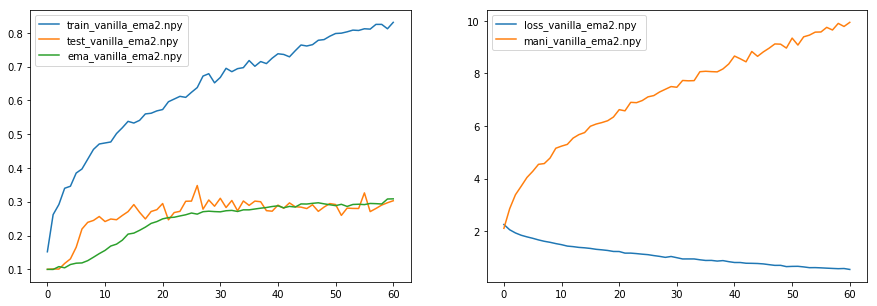

Epoch: 61,global_stp: 1240, xloss: 0.53978, maniloss: 10.16631, train: 83.30%, test: 32.66,test_ma: 30.26%
Epoch: 62,global_stp: 1260, xloss: 0.53978, maniloss: 10.39214, train: 84.30%, test: 29.81,test_ma: 30.23%
Epoch: 63,global_stp: 1280, xloss: 0.51766, maniloss: 10.31878, train: 85.10%, test: 30.00,test_ma: 30.00%
Epoch: 64,global_stp: 1300, xloss: 0.51403, maniloss: 10.33595, train: 84.70%, test: 31.86,test_ma: 31.16%
Epoch: 65,global_stp: 1320, xloss: 0.50032, maniloss: 10.32798, train: 84.20%, test: 30.88,test_ma: 30.45%
Epoch: 66,global_stp: 1340, xloss: 0.46836, maniloss: 10.54424, train: 86.80%, test: 30.74,test_ma: 30.24%
Epoch: 67,global_stp: 1360, xloss: 0.45582, maniloss: 10.40211, train: 87.20%, test: 27.82,test_ma: 30.31%
Epoch: 68,global_stp: 1380, xloss: 0.48723, maniloss: 10.74757, train: 85.50%, test: 33.51,test_ma: 30.67%
Epoch: 69,global_stp: 1400, xloss: 0.45736, maniloss: 10.84978, train: 86.80%, test: 29.64,test_ma: 29.95%
Epoch: 70,global_stp: 1420, xloss: 0.

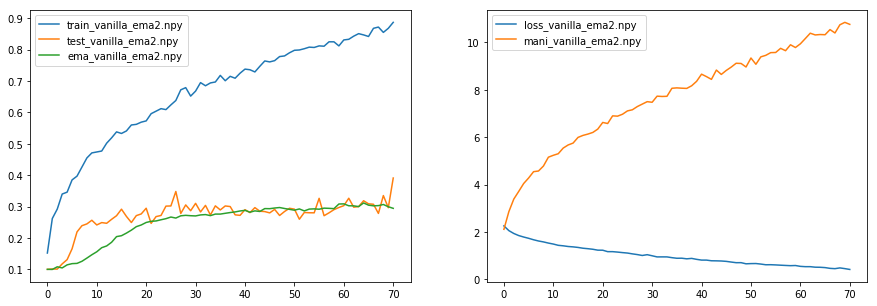

Epoch: 71,global_stp: 1440, xloss: 0.45106, maniloss: 10.76658, train: 86.40%, test: 29.18,test_ma: 29.89%
Epoch: 72,global_stp: 1460, xloss: 0.42536, maniloss: 10.98221, train: 87.70%, test: 30.76,test_ma: 29.84%
Epoch: 73,global_stp: 1480, xloss: 0.40897, maniloss: 10.97102, train: 88.80%, test: 30.10,test_ma: 30.98%
Epoch: 74,global_stp: 1500, xloss: 0.42883, maniloss: 10.75161, train: 87.50%, test: 33.50,test_ma: 30.41%
Epoch: 75,global_stp: 1520, xloss: 0.41429, maniloss: 10.96211, train: 88.10%, test: 30.68,test_ma: 31.33%
Epoch: 76,global_stp: 1540, xloss: 0.40298, maniloss: 11.13960, train: 88.60%, test: 28.84,test_ma: 31.74%
Epoch: 77,global_stp: 1560, xloss: 0.38545, maniloss: 11.07745, train: 90.80%, test: 31.97,test_ma: 31.41%
Epoch: 78,global_stp: 1580, xloss: 0.37126, maniloss: 11.21240, train: 90.90%, test: 30.79,test_ma: 31.92%
Epoch: 79,global_stp: 1600, xloss: 0.37423, maniloss: 11.14658, train: 91.60%, test: 31.38,test_ma: 32.93%
Epoch: 80,global_stp: 1620, xloss: 0.

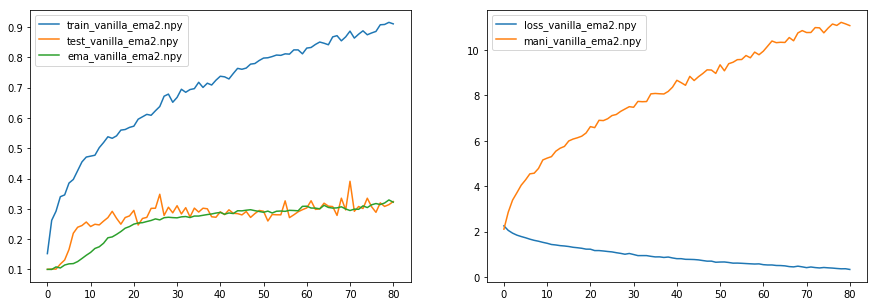

Epoch: 81,global_stp: 1640, xloss: 0.37324, maniloss: 11.47566, train: 89.90%, test: 31.34,test_ma: 32.45%
Epoch: 82,global_stp: 1660, xloss: 0.35780, maniloss: 11.74608, train: 90.30%, test: 31.12,test_ma: 31.83%
Epoch: 83,global_stp: 1680, xloss: 0.34801, maniloss: 11.42347, train: 90.80%, test: 32.89,test_ma: 30.76%
Epoch: 84,global_stp: 1700, xloss: 0.34541, maniloss: 11.43348, train: 90.60%, test: 31.83,test_ma: 31.60%
Epoch: 85,global_stp: 1720, xloss: 0.33222, maniloss: 11.45109, train: 91.50%, test: 28.97,test_ma: 32.38%
Epoch: 86,global_stp: 1740, xloss: 0.32554, maniloss: 11.61787, train: 91.40%, test: 31.01,test_ma: 32.61%
Epoch: 87,global_stp: 1760, xloss: 0.30832, maniloss: 11.67029, train: 92.30%, test: 30.33,test_ma: 33.75%
Epoch: 88,global_stp: 1780, xloss: 0.29190, maniloss: 11.86556, train: 93.30%, test: 33.03,test_ma: 33.76%
Epoch: 89,global_stp: 1800, xloss: 0.30226, maniloss: 11.53098, train: 91.80%, test: 30.60,test_ma: 33.69%
Epoch: 90,global_stp: 1820, xloss: 0.

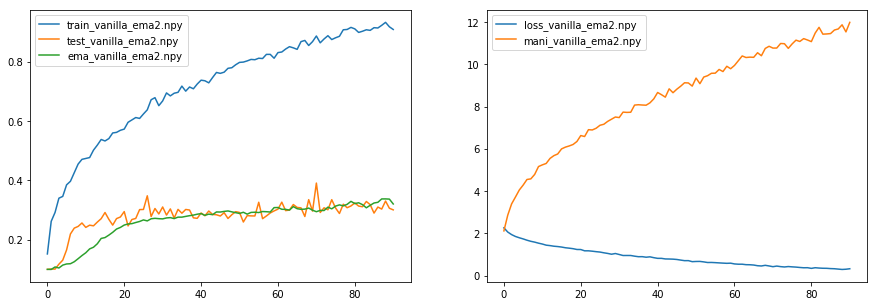

Epoch: 91,global_stp: 1840, xloss: 0.29742, maniloss: 11.75048, train: 92.70%, test: 37.54,test_ma: 32.02%
Epoch: 92,global_stp: 1860, xloss: 0.26380, maniloss: 12.01106, train: 93.70%, test: 31.73,test_ma: 32.16%
Epoch: 93,global_stp: 1880, xloss: 0.26988, maniloss: 11.88226, train: 94.40%, test: 32.71,test_ma: 32.23%
Epoch: 94,global_stp: 1900, xloss: 0.27714, maniloss: 11.96187, train: 92.30%, test: 33.08,test_ma: 32.42%
Epoch: 95,global_stp: 1920, xloss: 0.28461, maniloss: 11.99051, train: 91.90%, test: 33.03,test_ma: 33.26%
Epoch: 96,global_stp: 1940, xloss: 0.26954, maniloss: 12.15754, train: 93.40%, test: 32.77,test_ma: 33.82%
Epoch: 97,global_stp: 1960, xloss: 0.22561, maniloss: 11.99852, train: 95.90%, test: 35.65,test_ma: 34.96%
Epoch: 98,global_stp: 1980, xloss: 0.26055, maniloss: 12.16967, train: 93.70%, test: 31.41,test_ma: 34.07%
Epoch: 99,global_stp: 2000, xloss: 0.25987, maniloss: 12.39270, train: 93.60%, test: 32.16,test_ma: 34.25%
Epoch: 100,global_stp: 2020, xloss: 0

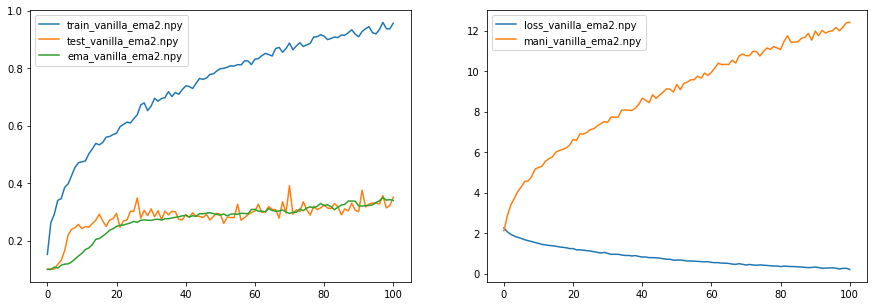

Epoch: 101,global_stp: 2040, xloss: 0.22650, maniloss: 12.35798, train: 94.70%, test: 32.75,test_ma: 34.01%
Epoch: 102,global_stp: 2060, xloss: 0.23695, maniloss: 12.27635, train: 94.40%, test: 34.22,test_ma: 35.42%
Epoch: 103,global_stp: 2080, xloss: 0.22678, maniloss: 12.58169, train: 94.80%, test: 33.59,test_ma: 34.27%
Epoch: 104,global_stp: 2100, xloss: 0.24299, maniloss: 12.33512, train: 93.60%, test: 34.00,test_ma: 35.72%
Epoch: 105,global_stp: 2120, xloss: 0.21773, maniloss: 12.80852, train: 95.60%, test: 31.83,test_ma: 35.09%
Epoch: 106,global_stp: 2140, xloss: 0.20386, maniloss: 12.70227, train: 95.00%, test: 37.08,test_ma: 34.32%
Epoch: 107,global_stp: 2160, xloss: 0.19967, maniloss: 12.75920, train: 95.30%, test: 36.02,test_ma: 33.78%
Epoch: 108,global_stp: 2180, xloss: 0.22480, maniloss: 12.91738, train: 94.30%, test: 35.90,test_ma: 34.22%
Epoch: 109,global_stp: 2200, xloss: 0.20685, maniloss: 12.96727, train: 95.40%, test: 32.91,test_ma: 34.16%
Epoch: 110,global_stp: 2220,

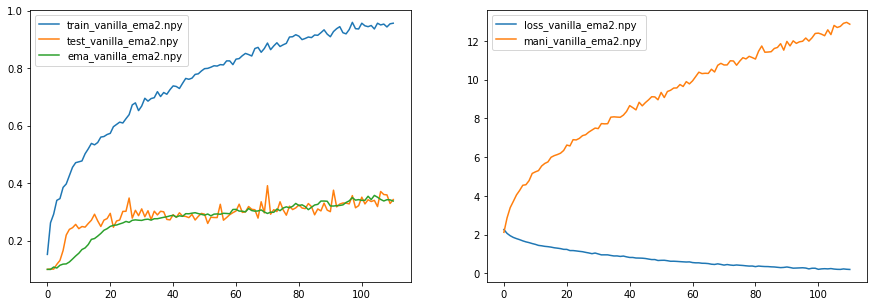

Epoch: 111,global_stp: 2240, xloss: 0.19704, maniloss: 12.86856, train: 95.50%, test: 33.93,test_ma: 34.90%
Epoch: 112,global_stp: 2260, xloss: 0.19622, maniloss: 12.88442, train: 95.20%, test: 30.97,test_ma: 34.87%
Epoch: 113,global_stp: 2280, xloss: 0.20399, maniloss: 13.07341, train: 95.40%, test: 36.08,test_ma: 34.33%
Epoch: 114,global_stp: 2300, xloss: 0.21489, maniloss: 12.81980, train: 94.10%, test: 33.01,test_ma: 34.87%
Epoch: 115,global_stp: 2320, xloss: 0.21136, maniloss: 12.82732, train: 94.00%, test: 31.50,test_ma: 35.42%
Epoch: 116,global_stp: 2340, xloss: 0.16788, maniloss: 13.05489, train: 96.70%, test: 35.69,test_ma: 34.49%
Epoch: 117,global_stp: 2360, xloss: 0.16622, maniloss: 12.86281, train: 96.00%, test: 35.91,test_ma: 34.81%
Epoch: 118,global_stp: 2380, xloss: 0.16278, maniloss: 13.13962, train: 96.20%, test: 32.91,test_ma: 34.89%
Epoch: 119,global_stp: 2400, xloss: 0.15484, maniloss: 13.20108, train: 96.10%, test: 36.74,test_ma: 35.03%
Epoch: 120,global_stp: 2420,

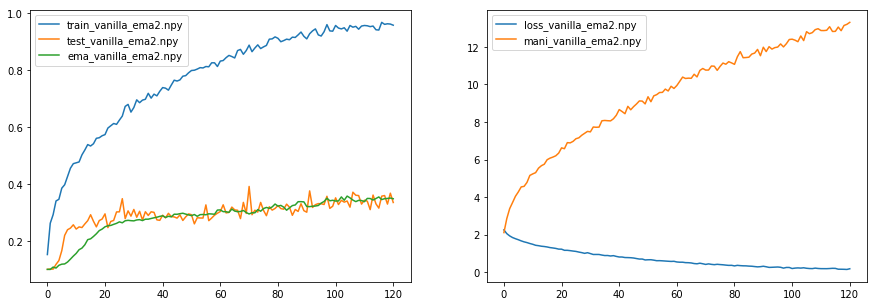

Epoch: 121,global_stp: 2440, xloss: 0.15433, maniloss: 13.25909, train: 96.80%, test: 33.14,test_ma: 35.19%
Epoch: 122,global_stp: 2460, xloss: 0.19009, maniloss: 13.26824, train: 94.80%, test: 33.76,test_ma: 34.82%
Epoch: 123,global_stp: 2480, xloss: 0.16569, maniloss: 13.56287, train: 95.90%, test: 32.56,test_ma: 34.10%
Epoch: 124,global_stp: 2500, xloss: 0.15409, maniloss: 13.42056, train: 96.90%, test: 36.24,test_ma: 34.74%
Epoch: 125,global_stp: 2520, xloss: 0.13377, maniloss: 13.43221, train: 98.00%, test: 32.69,test_ma: 34.20%
Epoch: 126,global_stp: 2540, xloss: 0.14335, maniloss: 13.19774, train: 96.80%, test: 34.02,test_ma: 35.12%
Epoch: 127,global_stp: 2560, xloss: 0.14932, maniloss: 13.50056, train: 96.50%, test: 37.53,test_ma: 34.32%
Epoch: 128,global_stp: 2580, xloss: 0.11533, maniloss: 13.47375, train: 97.90%, test: 33.82,test_ma: 34.67%
Epoch: 129,global_stp: 2600, xloss: 0.14772, maniloss: 13.84350, train: 96.40%, test: 32.98,test_ma: 34.07%
Epoch: 130,global_stp: 2620,

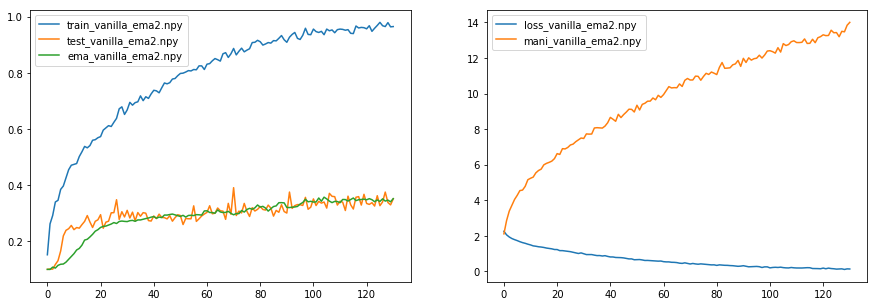

Epoch: 131,global_stp: 2640, xloss: 0.14018, maniloss: 13.55233, train: 97.40%, test: 34.27,test_ma: 34.62%
Epoch: 132,global_stp: 2660, xloss: 0.11819, maniloss: 13.79135, train: 98.00%, test: 30.76,test_ma: 34.91%
Epoch: 133,global_stp: 2680, xloss: 0.14308, maniloss: 13.64104, train: 96.50%, test: 38.18,test_ma: 35.87%
Epoch: 134,global_stp: 2700, xloss: 0.14146, maniloss: 13.64890, train: 97.10%, test: 36.62,test_ma: 35.28%
Epoch: 135,global_stp: 2720, xloss: 0.14280, maniloss: 13.72749, train: 97.00%, test: 34.05,test_ma: 35.87%
Epoch: 136,global_stp: 2740, xloss: 0.12700, maniloss: 13.74664, train: 97.50%, test: 43.12,test_ma: 34.92%
Epoch: 137,global_stp: 2760, xloss: 0.12833, maniloss: 13.90029, train: 97.00%, test: 36.27,test_ma: 35.21%
Epoch: 138,global_stp: 2780, xloss: 0.14878, maniloss: 13.61347, train: 96.20%, test: 35.88,test_ma: 33.62%
Epoch: 139,global_stp: 2800, xloss: 0.12578, maniloss: 13.58875, train: 97.50%, test: 38.25,test_ma: 36.00%
Epoch: 140,global_stp: 2820,

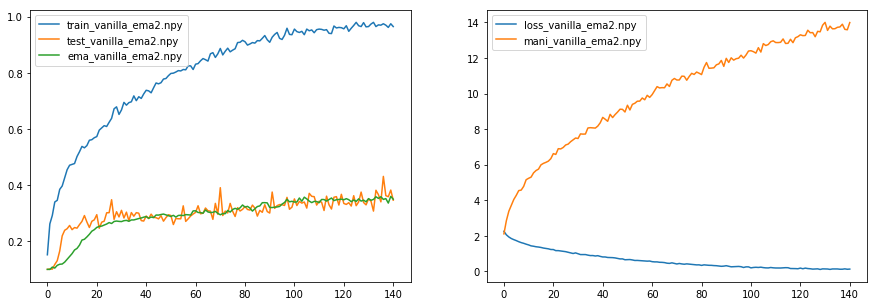

Epoch: 141,global_stp: 2840, xloss: 0.13289, maniloss: 14.02777, train: 97.50%, test: 33.69,test_ma: 36.39%
Epoch: 142,global_stp: 2860, xloss: 0.12486, maniloss: 13.64738, train: 97.10%, test: 33.11,test_ma: 38.06%
Epoch: 143,global_stp: 2880, xloss: 0.12066, maniloss: 14.03411, train: 97.50%, test: 33.56,test_ma: 37.95%
Epoch: 144,global_stp: 2900, xloss: 0.11140, maniloss: 14.44733, train: 97.10%, test: 35.47,test_ma: 37.92%
Epoch: 145,global_stp: 2920, xloss: 0.11870, maniloss: 14.21077, train: 97.10%, test: 40.14,test_ma: 37.69%
Epoch: 146,global_stp: 2940, xloss: 0.12297, maniloss: 13.94133, train: 97.70%, test: 37.08,test_ma: 36.93%
Epoch: 147,global_stp: 2960, xloss: 0.11182, maniloss: 14.42869, train: 97.90%, test: 37.36,test_ma: 36.45%
Epoch: 148,global_stp: 2980, xloss: 0.10339, maniloss: 14.48783, train: 97.90%, test: 33.84,test_ma: 37.28%
Epoch: 149,global_stp: 3000, xloss: 0.08634, maniloss: 14.32633, train: 99.00%, test: 35.20,test_ma: 38.43%
Epoch: 150,global_stp: 3020,

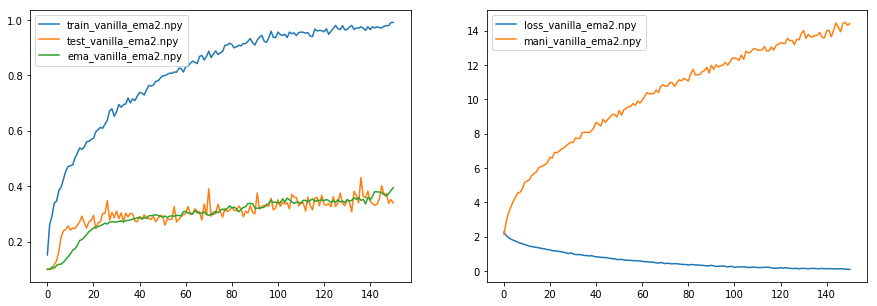

Epoch: 151,global_stp: 3040, xloss: 0.08765, maniloss: 14.51302, train: 98.10%, test: 39.00,test_ma: 39.83%
Epoch: 152,global_stp: 3060, xloss: 0.08770, maniloss: 14.18687, train: 98.50%, test: 36.34,test_ma: 37.90%
Epoch: 153,global_stp: 3080, xloss: 0.07910, maniloss: 14.31555, train: 98.60%, test: 39.78,test_ma: 37.98%
Epoch: 154,global_stp: 3100, xloss: 0.09139, maniloss: 14.36146, train: 98.50%, test: 36.88,test_ma: 36.90%
Epoch: 155,global_stp: 3120, xloss: 0.09435, maniloss: 14.38920, train: 98.30%, test: 36.69,test_ma: 37.60%
Epoch: 156,global_stp: 3140, xloss: 0.08973, maniloss: 14.42929, train: 98.30%, test: 36.22,test_ma: 37.21%
Epoch: 157,global_stp: 3160, xloss: 0.09190, maniloss: 14.65608, train: 98.20%, test: 37.24,test_ma: 37.22%
Epoch: 158,global_stp: 3180, xloss: 0.08948, maniloss: 14.28785, train: 97.80%, test: 38.91,test_ma: 38.14%
Epoch: 159,global_stp: 3200, xloss: 0.09095, maniloss: 14.79420, train: 98.10%, test: 37.50,test_ma: 37.65%
Epoch: 160,global_stp: 3220,

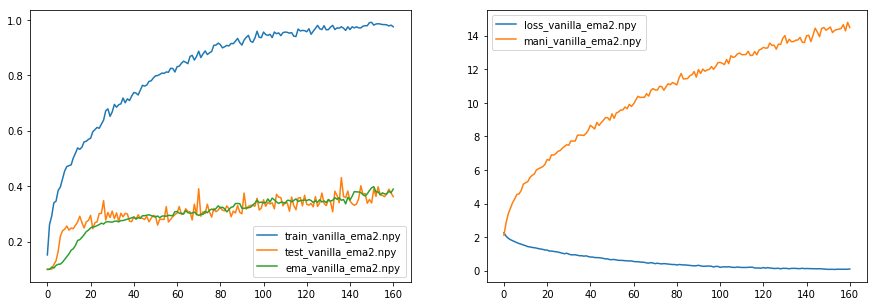

Epoch: 161,global_stp: 3240, xloss: 0.09754, maniloss: 14.52857, train: 97.80%, test: 35.78,test_ma: 38.65%
Epoch: 162,global_stp: 3260, xloss: 0.08886, maniloss: 14.54632, train: 98.00%, test: 38.63,test_ma: 37.07%
Epoch: 163,global_stp: 3280, xloss: 0.09733, maniloss: 14.72436, train: 97.50%, test: 37.05,test_ma: 36.53%
Epoch: 164,global_stp: 3300, xloss: 0.08353, maniloss: 14.44304, train: 98.60%, test: 36.24,test_ma: 36.87%
Epoch: 165,global_stp: 3320, xloss: 0.07425, maniloss: 15.01891, train: 98.90%, test: 38.07,test_ma: 37.02%
Epoch: 166,global_stp: 3340, xloss: 0.09225, maniloss: 14.58040, train: 97.90%, test: 35.68,test_ma: 37.16%
Epoch: 167,global_stp: 3360, xloss: 0.11971, maniloss: 14.53074, train: 96.70%, test: 35.83,test_ma: 37.03%
Epoch: 168,global_stp: 3380, xloss: 0.08525, maniloss: 14.58404, train: 98.50%, test: 35.56,test_ma: 36.86%
Epoch: 169,global_stp: 3400, xloss: 0.08441, maniloss: 14.74294, train: 98.10%, test: 37.31,test_ma: 37.44%
Epoch: 170,global_stp: 3420,

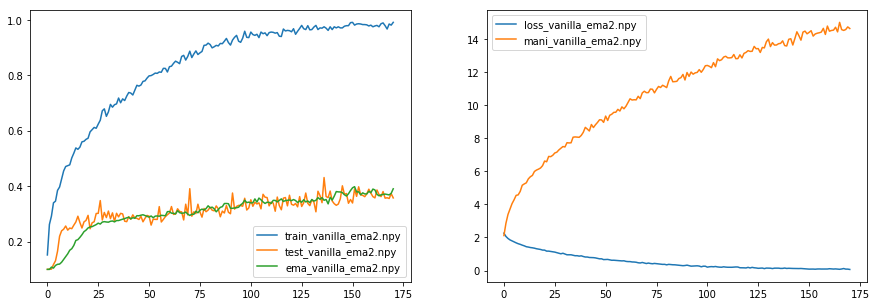

Epoch: 171,global_stp: 3440, xloss: 0.08168, maniloss: 14.63358, train: 98.50%, test: 36.75,test_ma: 39.86%
Epoch: 172,global_stp: 3460, xloss: 0.09093, maniloss: 14.72078, train: 97.70%, test: 39.33,test_ma: 39.88%
Epoch: 173,global_stp: 3480, xloss: 0.09734, maniloss: 14.80666, train: 97.70%, test: 40.19,test_ma: 38.57%
Epoch: 174,global_stp: 3500, xloss: 0.08920, maniloss: 14.69001, train: 98.10%, test: 37.36,test_ma: 38.33%
Epoch: 175,global_stp: 3520, xloss: 0.09462, maniloss: 14.99775, train: 97.50%, test: 38.35,test_ma: 38.15%
Epoch: 176,global_stp: 3540, xloss: 0.09494, maniloss: 15.06152, train: 97.70%, test: 37.60,test_ma: 37.65%
Epoch: 177,global_stp: 3560, xloss: 0.07323, maniloss: 14.77019, train: 98.80%, test: 35.16,test_ma: 38.39%
Epoch: 178,global_stp: 3580, xloss: 0.08911, maniloss: 15.06106, train: 98.20%, test: 38.37,test_ma: 38.00%
Epoch: 179,global_stp: 3600, xloss: 0.07964, maniloss: 15.03006, train: 98.20%, test: 40.00,test_ma: 36.97%
Epoch: 180,global_stp: 3620,

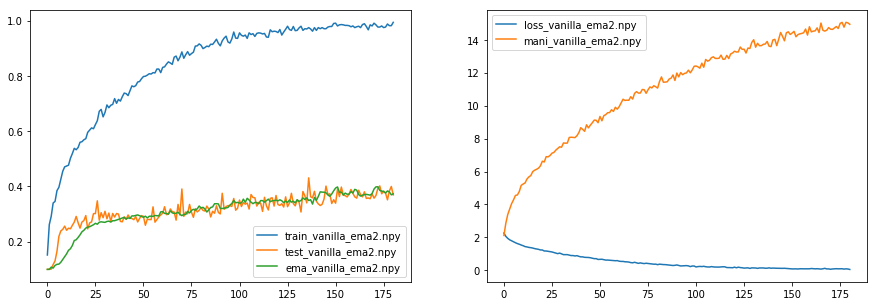

Epoch: 181,global_stp: 3640, xloss: 0.04804, maniloss: 15.16266, train: 99.50%, test: 39.51,test_ma: 38.91%
Epoch: 182,global_stp: 3660, xloss: 0.05640, maniloss: 15.15545, train: 99.30%, test: 38.71,test_ma: 37.44%
Epoch: 183,global_stp: 3680, xloss: 0.06711, maniloss: 15.48358, train: 98.70%, test: 38.24,test_ma: 38.67%
Epoch: 184,global_stp: 3700, xloss: 0.06276, maniloss: 15.37811, train: 98.80%, test: 36.92,test_ma: 37.87%
Epoch: 185,global_stp: 3720, xloss: 0.05993, maniloss: 15.51971, train: 99.10%, test: 37.93,test_ma: 39.41%
Epoch: 186,global_stp: 3740, xloss: 0.05130, maniloss: 15.76702, train: 99.30%, test: 37.22,test_ma: 39.61%
Epoch: 187,global_stp: 3760, xloss: 0.05352, maniloss: 15.71509, train: 99.00%, test: 37.00,test_ma: 39.17%
Epoch: 188,global_stp: 3780, xloss: 0.06037, maniloss: 15.32544, train: 99.20%, test: 41.01,test_ma: 39.43%
Epoch: 189,global_stp: 3800, xloss: 0.05017, maniloss: 15.74500, train: 99.30%, test: 37.00,test_ma: 39.70%
Epoch: 190,global_stp: 3820,

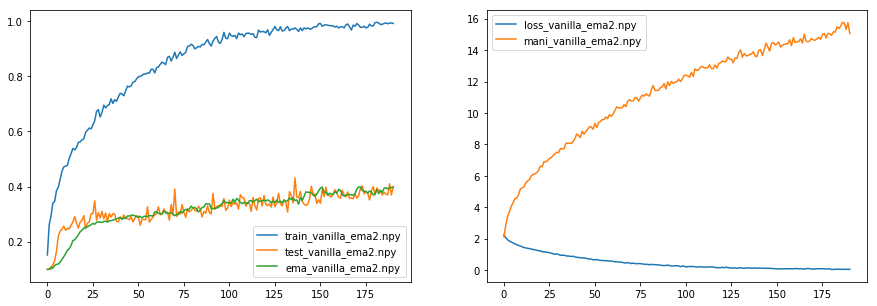

Epoch: 191,global_stp: 3840, xloss: 0.06357, maniloss: 15.66487, train: 98.90%, test: 38.49,test_ma: 39.50%
Epoch: 192,global_stp: 3860, xloss: 0.06792, maniloss: 15.54020, train: 98.40%, test: 38.44,test_ma: 38.86%
Epoch: 193,global_stp: 3880, xloss: 0.07415, maniloss: 15.37100, train: 98.80%, test: 38.08,test_ma: 39.49%
Epoch: 194,global_stp: 3900, xloss: 0.08667, maniloss: 15.30804, train: 97.40%, test: 36.96,test_ma: 39.93%
Epoch: 195,global_stp: 3920, xloss: 0.08228, maniloss: 15.42500, train: 97.80%, test: 36.79,test_ma: 39.65%
Epoch: 196,global_stp: 3940, xloss: 0.07160, maniloss: 15.84414, train: 98.90%, test: 40.52,test_ma: 39.37%
Epoch: 197,global_stp: 3960, xloss: 0.08511, maniloss: 15.35510, train: 98.10%, test: 37.15,test_ma: 39.39%
Epoch: 198,global_stp: 3980, xloss: 0.06912, maniloss: 15.69200, train: 98.60%, test: 41.79,test_ma: 38.97%
Epoch: 199,global_stp: 4000, xloss: 0.05759, maniloss: 15.42944, train: 99.00%, test: 37.92,test_ma: 39.04%
Epoch: 200,global_stp: 4020,

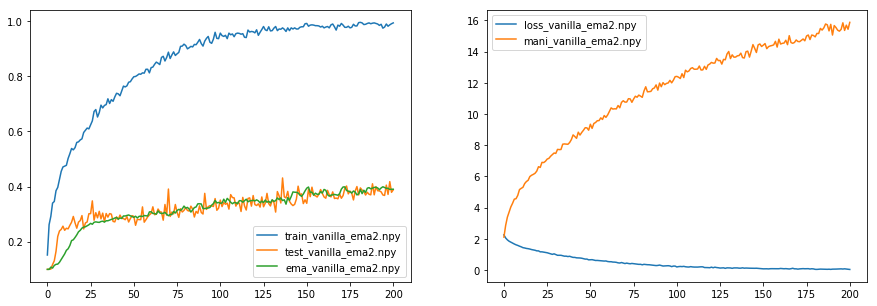

Epoch: 201,global_stp: 4040, xloss: 0.03878, maniloss: 15.68114, train: 99.50%, test: 40.41,test_ma: 40.32%
Epoch: 202,global_stp: 4060, xloss: 0.05076, maniloss: 16.03074, train: 98.90%, test: 37.30,test_ma: 39.56%
Epoch: 203,global_stp: 4080, xloss: 0.06136, maniloss: 15.82825, train: 98.80%, test: 41.31,test_ma: 39.42%
Epoch: 204,global_stp: 4100, xloss: 0.06371, maniloss: 15.73407, train: 98.70%, test: 39.10,test_ma: 39.35%
Epoch: 205,global_stp: 4120, xloss: 0.08321, maniloss: 15.63340, train: 98.20%, test: 42.39,test_ma: 39.75%
Epoch: 206,global_stp: 4140, xloss: 0.07754, maniloss: 15.68045, train: 97.40%, test: 34.89,test_ma: 39.70%
Epoch: 207,global_stp: 4160, xloss: 0.07866, maniloss: 15.57982, train: 98.10%, test: 40.64,test_ma: 39.99%
Epoch: 208,global_stp: 4180, xloss: 0.10255, maniloss: 16.05341, train: 97.30%, test: 39.91,test_ma: 40.19%
Epoch: 209,global_stp: 4200, xloss: 0.06991, maniloss: 15.58101, train: 98.00%, test: 42.11,test_ma: 39.15%
Epoch: 210,global_stp: 4220,

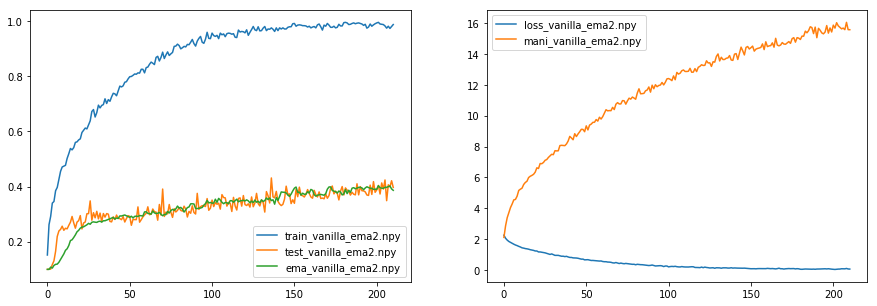

Epoch: 211,global_stp: 4240, xloss: 0.08123, maniloss: 15.92665, train: 97.70%, test: 37.13,test_ma: 40.41%
Epoch: 212,global_stp: 4260, xloss: 0.05102, maniloss: 16.01518, train: 99.20%, test: 41.11,test_ma: 41.06%
Epoch: 213,global_stp: 4280, xloss: 0.05061, maniloss: 16.29255, train: 99.30%, test: 38.27,test_ma: 42.01%
Epoch: 214,global_stp: 4300, xloss: 0.04011, maniloss: 16.14931, train: 99.50%, test: 37.59,test_ma: 43.40%
Epoch: 215,global_stp: 4320, xloss: 0.04867, maniloss: 15.67575, train: 99.10%, test: 41.36,test_ma: 43.51%
Epoch: 216,global_stp: 4340, xloss: 0.04553, maniloss: 15.86593, train: 99.20%, test: 42.02,test_ma: 40.87%
Epoch: 217,global_stp: 4360, xloss: 0.06813, maniloss: 15.85549, train: 98.00%, test: 41.24,test_ma: 40.05%
Epoch: 218,global_stp: 4380, xloss: 0.05207, maniloss: 16.16499, train: 99.00%, test: 37.09,test_ma: 40.16%
Epoch: 219,global_stp: 4400, xloss: 0.05556, maniloss: 15.48590, train: 98.90%, test: 38.37,test_ma: 41.54%
Epoch: 220,global_stp: 4420,

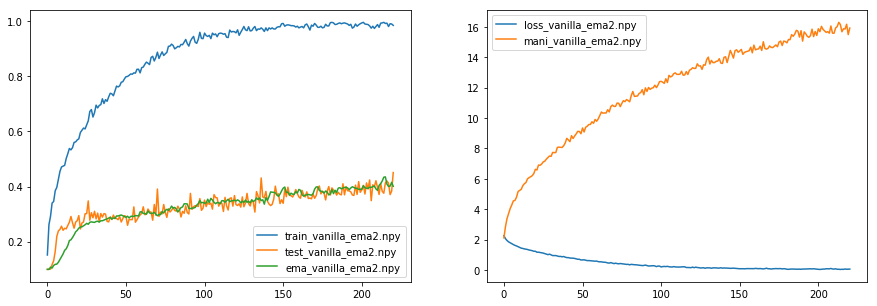

Epoch: 221,global_stp: 4440, xloss: 0.07861, maniloss: 16.05564, train: 97.70%, test: 38.89,test_ma: 40.32%
Epoch: 222,global_stp: 4460, xloss: 0.07557, maniloss: 15.96296, train: 98.30%, test: 36.68,test_ma: 41.55%
Epoch: 223,global_stp: 4480, xloss: 0.06066, maniloss: 15.86463, train: 98.80%, test: 41.16,test_ma: 41.84%
Epoch: 224,global_stp: 4500, xloss: 0.05264, maniloss: 16.21853, train: 98.70%, test: 39.30,test_ma: 41.60%
Epoch: 225,global_stp: 4520, xloss: 0.04483, maniloss: 15.90514, train: 99.20%, test: 42.22,test_ma: 41.89%
Epoch: 226,global_stp: 4540, xloss: 0.05429, maniloss: 16.56970, train: 98.70%, test: 41.30,test_ma: 40.19%
Epoch: 227,global_stp: 4560, xloss: 0.04529, maniloss: 16.23653, train: 99.60%, test: 38.13,test_ma: 41.67%
Epoch: 228,global_stp: 4580, xloss: 0.04720, maniloss: 16.59965, train: 99.10%, test: 40.66,test_ma: 41.70%
Epoch: 229,global_stp: 4600, xloss: 0.06345, maniloss: 16.41483, train: 98.60%, test: 39.91,test_ma: 43.22%
Epoch: 230,global_stp: 4620,

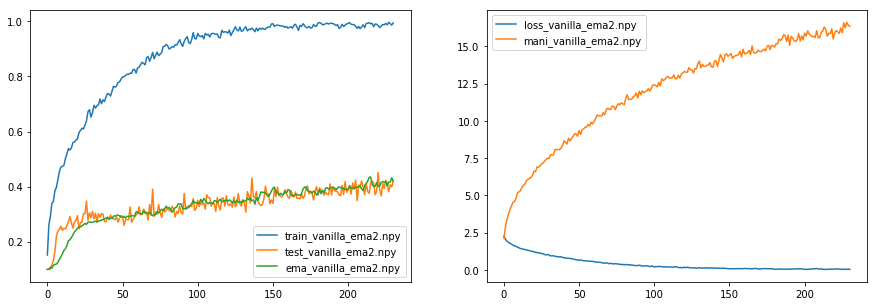

Epoch: 231,global_stp: 4640, xloss: 0.04667, maniloss: 16.41586, train: 99.10%, test: 37.85,test_ma: 41.48%
Epoch: 232,global_stp: 4660, xloss: 0.04258, maniloss: 16.38413, train: 99.20%, test: 40.59,test_ma: 41.67%
Epoch: 233,global_stp: 4680, xloss: 0.05834, maniloss: 16.30131, train: 98.40%, test: 38.40,test_ma: 42.02%
Epoch: 234,global_stp: 4700, xloss: 0.06814, maniloss: 16.31469, train: 98.10%, test: 36.80,test_ma: 42.47%
Epoch: 235,global_stp: 4720, xloss: 0.05498, maniloss: 16.12443, train: 99.10%, test: 42.32,test_ma: 42.92%
Epoch: 236,global_stp: 4740, xloss: 0.04338, maniloss: 16.27956, train: 99.10%, test: 42.30,test_ma: 41.30%
Epoch: 237,global_stp: 4760, xloss: 0.03131, maniloss: 16.54728, train: 99.80%, test: 42.59,test_ma: 41.74%
Epoch: 238,global_stp: 4780, xloss: 0.03596, maniloss: 16.78405, train: 99.50%, test: 41.67,test_ma: 40.59%
Epoch: 239,global_stp: 4800, xloss: 0.03816, maniloss: 16.71056, train: 99.40%, test: 37.94,test_ma: 40.01%
Epoch: 240,global_stp: 4820,

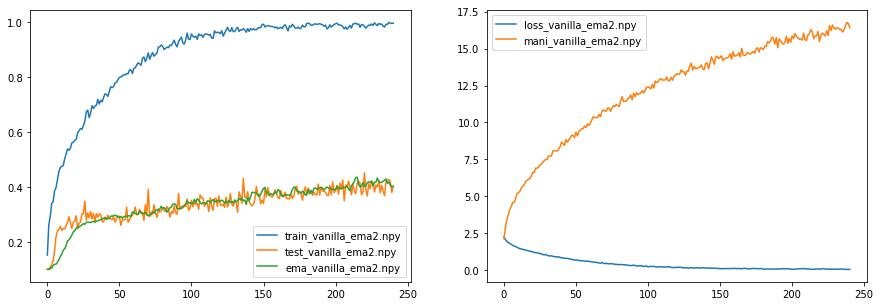

Epoch: 241,global_stp: 4840, xloss: 0.04903, maniloss: 16.26419, train: 99.00%, test: 41.00,test_ma: 40.63%
Epoch: 242,global_stp: 4860, xloss: 0.06428, maniloss: 16.52825, train: 98.40%, test: 41.50,test_ma: 39.94%
Epoch: 243,global_stp: 4880, xloss: 0.05904, maniloss: 16.88769, train: 98.50%, test: 37.56,test_ma: 39.44%
Epoch: 244,global_stp: 4900, xloss: 0.04671, maniloss: 16.18093, train: 99.00%, test: 39.58,test_ma: 39.42%
Epoch: 245,global_stp: 4920, xloss: 0.03460, maniloss: 16.78199, train: 99.60%, test: 39.21,test_ma: 40.11%
Epoch: 246,global_stp: 4940, xloss: 0.03978, maniloss: 16.55341, train: 99.20%, test: 42.12,test_ma: 40.46%
Epoch: 247,global_stp: 4960, xloss: 0.04136, maniloss: 16.77417, train: 99.00%, test: 40.85,test_ma: 39.67%
Epoch: 248,global_stp: 4980, xloss: 0.04876, maniloss: 16.76019, train: 98.80%, test: 40.77,test_ma: 39.90%
Epoch: 249,global_stp: 5000, xloss: 0.04383, maniloss: 16.30112, train: 98.90%, test: 38.70,test_ma: 40.45%
Epoch: 250,global_stp: 5020,

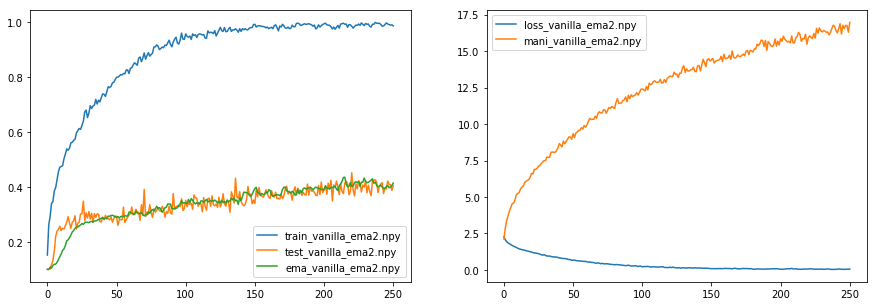

Epoch: 251,global_stp: 5040, xloss: 0.04612, maniloss: 16.51872, train: 98.70%, test: 36.86,test_ma: 41.35%
Epoch: 252,global_stp: 5060, xloss: 0.03496, maniloss: 16.09430, train: 99.50%, test: 40.68,test_ma: 42.14%
Epoch: 253,global_stp: 5080, xloss: 0.03549, maniloss: 16.73951, train: 99.20%, test: 39.90,test_ma: 42.61%
Epoch: 254,global_stp: 5100, xloss: 0.05297, maniloss: 16.93613, train: 98.70%, test: 41.19,test_ma: 42.60%
Epoch: 255,global_stp: 5120, xloss: 0.05946, maniloss: 16.68917, train: 98.30%, test: 40.61,test_ma: 41.84%
Epoch: 256,global_stp: 5140, xloss: 0.05163, maniloss: 16.50651, train: 98.60%, test: 37.91,test_ma: 42.05%
Epoch: 257,global_stp: 5160, xloss: 0.06221, maniloss: 16.45811, train: 98.20%, test: 37.10,test_ma: 41.54%
Epoch: 258,global_stp: 5180, xloss: 0.04738, maniloss: 16.86126, train: 99.10%, test: 42.16,test_ma: 42.37%
Epoch: 259,global_stp: 5200, xloss: 0.04792, maniloss: 17.09365, train: 98.80%, test: 43.54,test_ma: 40.78%
Epoch: 260,global_stp: 5220,

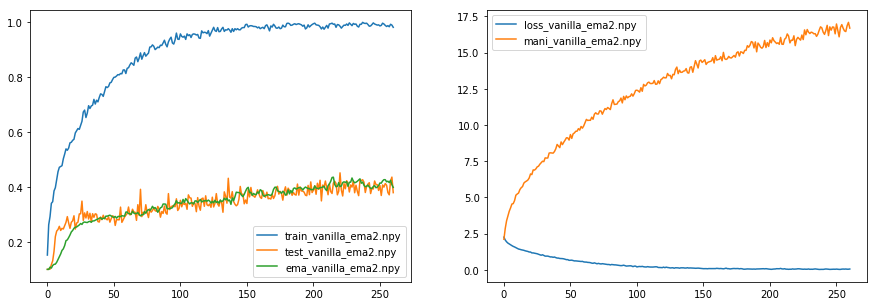

Epoch: 261,global_stp: 5240, xloss: 0.07505, maniloss: 17.07668, train: 97.90%, test: 37.41,test_ma: 40.06%
Epoch: 262,global_stp: 5260, xloss: 0.06890, maniloss: 16.93652, train: 97.60%, test: 40.28,test_ma: 40.07%
Epoch: 263,global_stp: 5280, xloss: 0.05466, maniloss: 16.77033, train: 98.80%, test: 41.13,test_ma: 40.77%
Epoch: 264,global_stp: 5300, xloss: 0.04470, maniloss: 16.97456, train: 99.20%, test: 43.46,test_ma: 40.15%
Epoch: 265,global_stp: 5320, xloss: 0.04052, maniloss: 16.77502, train: 98.80%, test: 39.05,test_ma: 40.42%
Epoch: 266,global_stp: 5340, xloss: 0.04325, maniloss: 16.96319, train: 99.20%, test: 41.34,test_ma: 42.17%
Epoch: 267,global_stp: 5360, xloss: 0.03557, maniloss: 17.00440, train: 99.10%, test: 41.92,test_ma: 42.41%
Epoch: 268,global_stp: 5380, xloss: 0.03139, maniloss: 16.85181, train: 99.50%, test: 41.94,test_ma: 41.76%
Epoch: 269,global_stp: 5400, xloss: 0.02822, maniloss: 17.12723, train: 99.70%, test: 43.61,test_ma: 41.42%
Epoch: 270,global_stp: 5420,

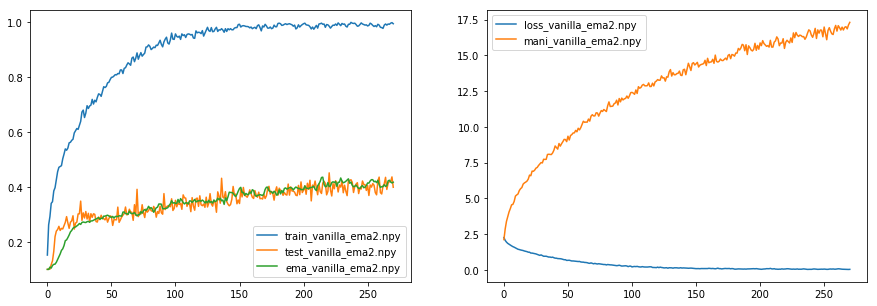

Epoch: 271,global_stp: 5440, xloss: 0.03610, maniloss: 16.91280, train: 99.50%, test: 40.99,test_ma: 42.99%
Epoch: 272,global_stp: 5460, xloss: 0.02635, maniloss: 17.21196, train: 99.60%, test: 40.90,test_ma: 43.21%
Epoch: 273,global_stp: 5480, xloss: 0.03276, maniloss: 17.29628, train: 99.40%, test: 40.40,test_ma: 43.18%
Epoch: 274,global_stp: 5500, xloss: 0.02431, maniloss: 16.84054, train: 99.50%, test: 44.16,test_ma: 41.67%
Epoch: 275,global_stp: 5520, xloss: 0.03290, maniloss: 16.73294, train: 99.30%, test: 41.88,test_ma: 42.36%
Epoch: 276,global_stp: 5540, xloss: 0.04015, maniloss: 17.17945, train: 99.20%, test: 41.10,test_ma: 41.36%
Epoch: 277,global_stp: 5560, xloss: 0.04177, maniloss: 16.70051, train: 99.30%, test: 41.34,test_ma: 43.13%
Epoch: 278,global_stp: 5580, xloss: 0.03793, maniloss: 17.02168, train: 99.60%, test: 45.23,test_ma: 42.49%
Epoch: 279,global_stp: 5600, xloss: 0.03519, maniloss: 16.80456, train: 99.20%, test: 37.27,test_ma: 42.18%
Epoch: 280,global_stp: 5620,

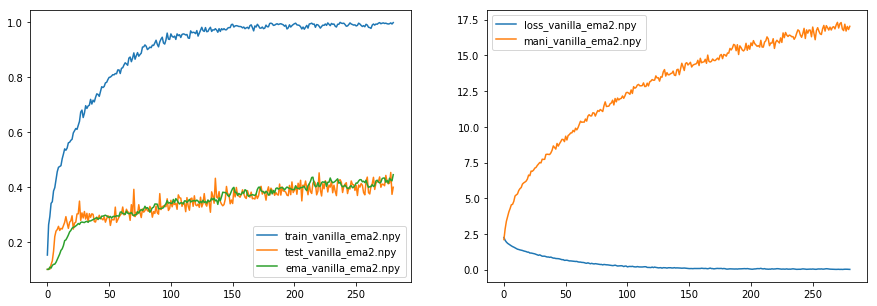

Epoch: 281,global_stp: 5640, xloss: 0.04199, maniloss: 17.22134, train: 99.00%, test: 43.09,test_ma: 43.40%
Epoch: 282,global_stp: 5660, xloss: 0.04449, maniloss: 17.34938, train: 99.10%, test: 40.43,test_ma: 42.76%
Epoch: 283,global_stp: 5680, xloss: 0.05110, maniloss: 17.33281, train: 98.80%, test: 43.96,test_ma: 41.81%
Epoch: 284,global_stp: 5700, xloss: 0.03651, maniloss: 17.15057, train: 99.30%, test: 42.06,test_ma: 41.77%
Epoch: 285,global_stp: 5720, xloss: 0.02766, maniloss: 17.18557, train: 99.60%, test: 39.28,test_ma: 40.96%
Epoch: 286,global_stp: 5740, xloss: 0.02083, maniloss: 17.25011, train: 99.60%, test: 40.34,test_ma: 42.69%
Epoch: 287,global_stp: 5760, xloss: 0.03208, maniloss: 17.34629, train: 99.70%, test: 41.11,test_ma: 42.37%
Epoch: 288,global_stp: 5780, xloss: 0.04433, maniloss: 17.53568, train: 98.80%, test: 40.10,test_ma: 44.10%
Epoch: 289,global_stp: 5800, xloss: 0.06033, maniloss: 17.25276, train: 97.80%, test: 43.10,test_ma: 44.03%
Epoch: 290,global_stp: 5820,

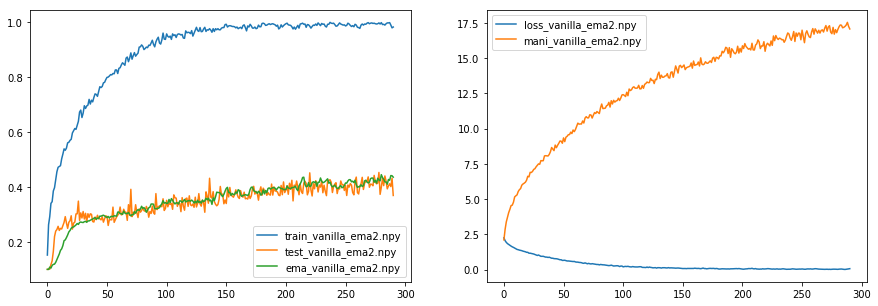

Epoch: 291,global_stp: 5840, xloss: 0.03342, maniloss: 17.60106, train: 99.60%, test: 44.10,test_ma: 44.42%
Epoch: 292,global_stp: 5860, xloss: 0.03336, maniloss: 17.35203, train: 99.40%, test: 40.36,test_ma: 44.13%
Epoch: 293,global_stp: 5880, xloss: 0.06896, maniloss: 17.55982, train: 98.30%, test: 45.86,test_ma: 42.78%
Epoch: 294,global_stp: 5900, xloss: 0.04796, maniloss: 17.83503, train: 98.80%, test: 42.55,test_ma: 40.93%
Epoch: 295,global_stp: 5920, xloss: 0.03204, maniloss: 17.26039, train: 99.80%, test: 40.58,test_ma: 41.01%
Epoch: 296,global_stp: 5940, xloss: 0.02921, maniloss: 17.42137, train: 99.40%, test: 40.45,test_ma: 43.13%
Epoch: 297,global_stp: 5960, xloss: 0.02782, maniloss: 17.12657, train: 99.60%, test: 42.64,test_ma: 43.66%
Epoch: 298,global_stp: 5980, xloss: 0.02632, maniloss: 17.32265, train: 99.80%, test: 41.13,test_ma: 43.28%
Epoch: 299,global_stp: 6000, xloss: 0.02513, maniloss: 17.81041, train: 99.70%, test: 43.25,test_ma: 43.42%
Epoch: 300,global_stp: 6020,

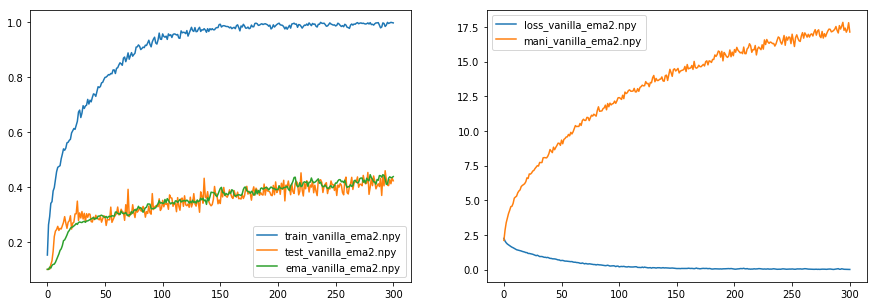

Epoch: 301,global_stp: 6040, xloss: 0.01945, maniloss: 17.27545, train: 99.90%, test: 43.80,test_ma: 43.72%
Epoch: 302,global_stp: 6060, xloss: 0.03136, maniloss: 17.24091, train: 99.20%, test: 39.90,test_ma: 44.10%
Epoch: 303,global_stp: 6080, xloss: 0.04293, maniloss: 17.42253, train: 98.80%, test: 40.36,test_ma: 44.18%
Epoch: 304,global_stp: 6100, xloss: 0.02890, maniloss: 17.17359, train: 99.40%, test: 40.80,test_ma: 44.75%
Epoch: 305,global_stp: 6120, xloss: 0.02674, maniloss: 17.61328, train: 99.50%, test: 40.45,test_ma: 44.82%
Epoch: 306,global_stp: 6140, xloss: 0.03261, maniloss: 17.65332, train: 99.60%, test: 41.95,test_ma: 43.41%
Epoch: 307,global_stp: 6160, xloss: 0.05557, maniloss: 17.37539, train: 98.70%, test: 41.37,test_ma: 42.47%
Epoch: 308,global_stp: 6180, xloss: 0.05093, maniloss: 17.73111, train: 98.60%, test: 41.29,test_ma: 43.56%
Epoch: 309,global_stp: 6200, xloss: 0.05227, maniloss: 17.52279, train: 98.70%, test: 44.91,test_ma: 42.91%
Epoch: 310,global_stp: 6220,

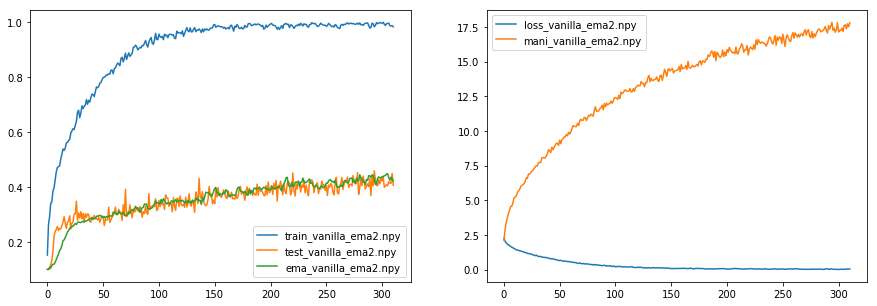

Epoch: 311,global_stp: 6240, xloss: 0.05221, maniloss: 17.82199, train: 98.80%, test: 43.01,test_ma: 41.71%
Epoch: 312,global_stp: 6260, xloss: 0.04566, maniloss: 17.91136, train: 98.80%, test: 40.45,test_ma: 41.56%
Epoch: 313,global_stp: 6280, xloss: 0.03103, maniloss: 17.57243, train: 99.50%, test: 43.40,test_ma: 42.93%
Epoch: 314,global_stp: 6300, xloss: 0.03879, maniloss: 17.90604, train: 98.80%, test: 42.12,test_ma: 41.94%
Epoch: 315,global_stp: 6320, xloss: 0.02557, maniloss: 17.57804, train: 99.80%, test: 43.04,test_ma: 42.81%
Epoch: 316,global_stp: 6340, xloss: 0.04165, maniloss: 17.80111, train: 98.90%, test: 40.77,test_ma: 43.39%
Epoch: 317,global_stp: 6360, xloss: 0.03084, maniloss: 17.60125, train: 99.20%, test: 43.93,test_ma: 44.08%
Epoch: 318,global_stp: 6380, xloss: 0.02726, maniloss: 18.04419, train: 99.70%, test: 45.61,test_ma: 44.46%
Epoch: 319,global_stp: 6400, xloss: 0.03339, maniloss: 17.82116, train: 98.90%, test: 40.28,test_ma: 43.14%
Epoch: 320,global_stp: 6420,

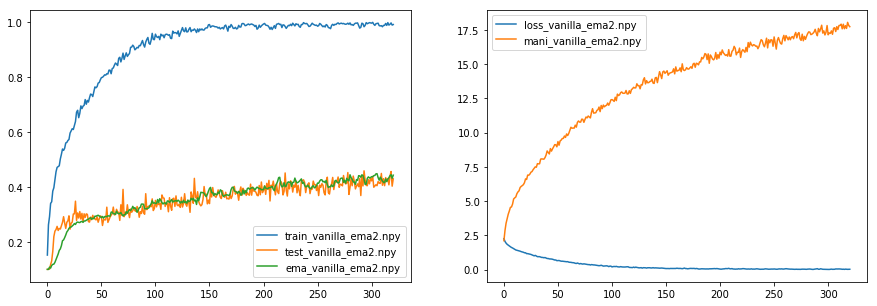

Epoch: 321,global_stp: 6440, xloss: 0.02776, maniloss: 17.58385, train: 99.60%, test: 42.43,test_ma: 43.82%
Epoch: 322,global_stp: 6460, xloss: 0.02343, maniloss: 18.00787, train: 99.50%, test: 42.02,test_ma: 44.36%
Epoch: 323,global_stp: 6480, xloss: 0.01527, maniloss: 17.86822, train: 99.80%, test: 45.32,test_ma: 45.31%
Epoch: 324,global_stp: 6500, xloss: 0.02856, maniloss: 17.78051, train: 98.90%, test: 42.55,test_ma: 43.78%
Epoch: 325,global_stp: 6520, xloss: 0.04441, maniloss: 17.76783, train: 98.80%, test: 42.95,test_ma: 43.88%
Epoch: 326,global_stp: 6540, xloss: 0.05699, maniloss: 17.91520, train: 98.30%, test: 46.38,test_ma: 41.28%
Epoch: 327,global_stp: 6560, xloss: 0.04743, maniloss: 18.27253, train: 98.70%, test: 45.11,test_ma: 40.53%
Epoch: 328,global_stp: 6580, xloss: 0.05709, maniloss: 18.06863, train: 98.40%, test: 40.36,test_ma: 42.30%
Epoch: 329,global_stp: 6600, xloss: 0.03890, maniloss: 18.00258, train: 99.30%, test: 41.59,test_ma: 43.81%
Epoch: 330,global_stp: 6620,

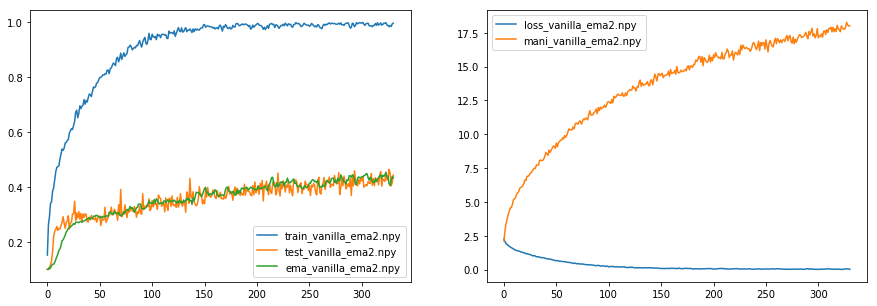

Epoch: 331,global_stp: 6640, xloss: 0.02322, maniloss: 18.16621, train: 99.50%, test: 41.78,test_ma: 42.37%
Epoch: 332,global_stp: 6660, xloss: 0.02894, maniloss: 18.36746, train: 99.20%, test: 38.45,test_ma: 43.46%
Epoch: 333,global_stp: 6680, xloss: 0.03931, maniloss: 17.63283, train: 98.80%, test: 40.59,test_ma: 44.62%
Epoch: 334,global_stp: 6700, xloss: 0.03510, maniloss: 18.01756, train: 99.10%, test: 43.67,test_ma: 44.20%
Epoch: 335,global_stp: 6720, xloss: 0.04018, maniloss: 17.96823, train: 98.90%, test: 43.50,test_ma: 44.35%
Epoch: 336,global_stp: 6740, xloss: 0.02864, maniloss: 18.56438, train: 99.50%, test: 43.54,test_ma: 44.28%
Epoch: 337,global_stp: 6760, xloss: 0.03895, maniloss: 17.98089, train: 99.30%, test: 39.68,test_ma: 44.62%
Epoch: 338,global_stp: 6780, xloss: 0.04431, maniloss: 18.15288, train: 99.20%, test: 44.20,test_ma: 45.41%
Epoch: 339,global_stp: 6800, xloss: 0.02154, maniloss: 17.84101, train: 99.80%, test: 42.64,test_ma: 44.23%
Epoch: 340,global_stp: 6820,

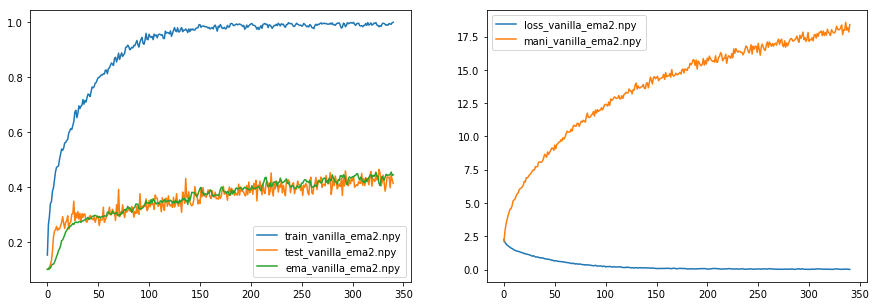

Epoch: 341,global_stp: 6840, xloss: 0.01284, maniloss: 17.64198, train: 100.00%, test: 43.98,test_ma: 44.46%
Epoch: 342,global_stp: 6860, xloss: 0.01251, maniloss: 18.08822, train: 99.90%, test: 45.43,test_ma: 43.27%
Epoch: 343,global_stp: 6880, xloss: 0.02384, maniloss: 18.22414, train: 99.50%, test: 42.62,test_ma: 44.04%
Epoch: 344,global_stp: 6900, xloss: 0.02001, maniloss: 18.49615, train: 99.80%, test: 42.69,test_ma: 44.41%
Epoch: 345,global_stp: 6920, xloss: 0.01799, maniloss: 18.25447, train: 99.60%, test: 43.26,test_ma: 43.87%
Epoch: 346,global_stp: 6940, xloss: 0.01996, maniloss: 18.25032, train: 99.80%, test: 40.50,test_ma: 43.70%
Epoch: 347,global_stp: 6960, xloss: 0.02341, maniloss: 18.14832, train: 99.60%, test: 41.32,test_ma: 44.80%
Epoch: 348,global_stp: 6980, xloss: 0.02471, maniloss: 18.08610, train: 99.50%, test: 38.87,test_ma: 43.16%
Epoch: 349,global_stp: 7000, xloss: 0.02619, maniloss: 18.19938, train: 99.80%, test: 44.21,test_ma: 43.44%
Epoch: 350,global_stp: 7020

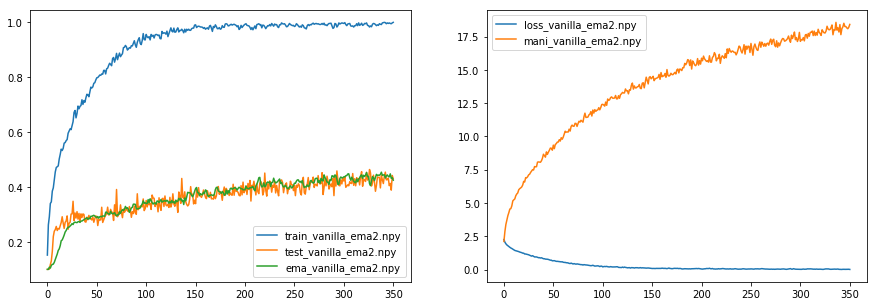

Epoch: 351,global_stp: 7040, xloss: 0.02718, maniloss: 18.50690, train: 99.30%, test: 42.99,test_ma: 42.92%
Epoch: 352,global_stp: 7060, xloss: 0.02170, maniloss: 18.74215, train: 99.70%, test: 42.89,test_ma: 44.10%
Epoch: 353,global_stp: 7080, xloss: 0.02357, maniloss: 18.69506, train: 99.50%, test: 46.12,test_ma: 42.65%
Epoch: 354,global_stp: 7100, xloss: 0.03206, maniloss: 18.65310, train: 99.30%, test: 45.24,test_ma: 41.62%
Epoch: 355,global_stp: 7120, xloss: 0.01977, maniloss: 18.50006, train: 99.70%, test: 43.24,test_ma: 41.72%
Epoch: 356,global_stp: 7140, xloss: 0.03388, maniloss: 18.83862, train: 99.10%, test: 39.76,test_ma: 43.38%
Epoch: 357,global_stp: 7160, xloss: 0.02641, maniloss: 18.40876, train: 99.50%, test: 38.96,test_ma: 44.32%
Epoch: 358,global_stp: 7180, xloss: 0.02819, maniloss: 18.73504, train: 99.50%, test: 42.31,test_ma: 44.71%
Epoch: 359,global_stp: 7200, xloss: 0.02203, maniloss: 18.79303, train: 99.60%, test: 45.58,test_ma: 44.27%
Epoch: 360,global_stp: 7220,

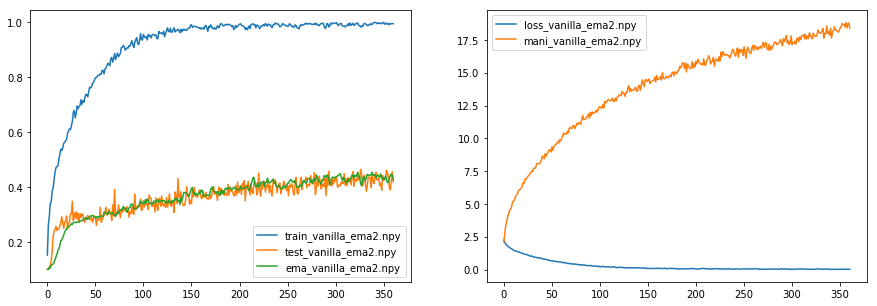

Epoch: 361,global_stp: 7240, xloss: 0.01740, maniloss: 18.62436, train: 99.70%, test: 44.68,test_ma: 45.34%
Epoch: 362,global_stp: 7260, xloss: 0.01115, maniloss: 18.56020, train: 99.80%, test: 46.45,test_ma: 44.39%
Epoch: 363,global_stp: 7280, xloss: 0.03740, maniloss: 18.51610, train: 99.00%, test: 42.02,test_ma: 44.43%
Epoch: 364,global_stp: 7300, xloss: 0.02336, maniloss: 18.70422, train: 99.30%, test: 43.36,test_ma: 46.64%
Epoch: 365,global_stp: 7320, xloss: 0.02662, maniloss: 18.67110, train: 99.50%, test: 40.81,test_ma: 45.94%
Epoch: 366,global_stp: 7340, xloss: 0.03274, maniloss: 19.04049, train: 99.30%, test: 42.84,test_ma: 44.31%
Epoch: 367,global_stp: 7360, xloss: 0.02698, maniloss: 18.22878, train: 99.30%, test: 42.95,test_ma: 44.68%
Epoch: 368,global_stp: 7380, xloss: 0.02023, maniloss: 18.58806, train: 99.50%, test: 41.79,test_ma: 45.46%
Epoch: 369,global_stp: 7400, xloss: 0.03260, maniloss: 18.60332, train: 99.10%, test: 42.08,test_ma: 46.09%
Epoch: 370,global_stp: 7420,

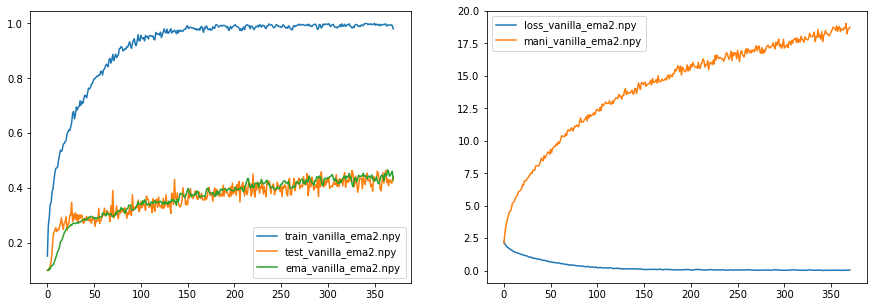

Epoch: 371,global_stp: 7440, xloss: 0.05523, maniloss: 18.88081, train: 98.20%, test: 44.61,test_ma: 43.53%
Epoch: 372,global_stp: 7460, xloss: 0.07163, maniloss: 18.96915, train: 98.30%, test: 45.62,test_ma: 41.57%
Epoch: 373,global_stp: 7480, xloss: 0.05221, maniloss: 18.67253, train: 98.70%, test: 43.22,test_ma: 41.19%
Epoch: 374,global_stp: 7500, xloss: 0.05201, maniloss: 18.79573, train: 98.60%, test: 45.31,test_ma: 40.19%
Epoch: 375,global_stp: 7520, xloss: 0.03563, maniloss: 18.78944, train: 99.30%, test: 38.80,test_ma: 41.59%
Epoch: 376,global_stp: 7540, xloss: 0.03688, maniloss: 18.83558, train: 98.70%, test: 44.36,test_ma: 43.21%
Epoch: 377,global_stp: 7560, xloss: 0.03742, maniloss: 18.16707, train: 99.20%, test: 40.65,test_ma: 43.52%
Epoch: 378,global_stp: 7580, xloss: 0.02240, maniloss: 18.12603, train: 99.60%, test: 42.75,test_ma: 46.14%
Epoch: 379,global_stp: 7600, xloss: 0.02091, maniloss: 18.76925, train: 99.30%, test: 47.50,test_ma: 46.80%
Epoch: 380,global_stp: 7620,

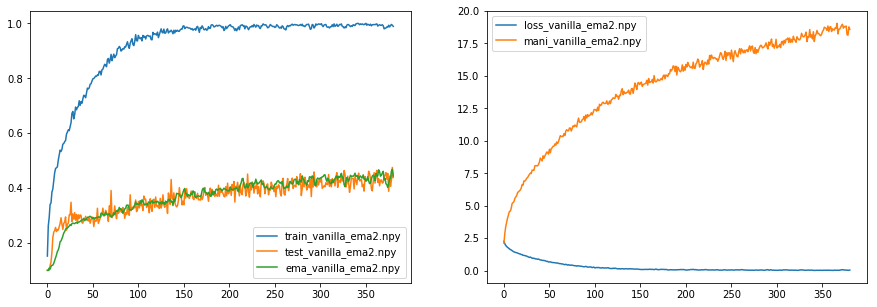

Epoch: 381,global_stp: 7640, xloss: 0.05478, maniloss: 19.12393, train: 98.60%, test: 45.10,test_ma: 43.95%
Epoch: 382,global_stp: 7660, xloss: 0.04524, maniloss: 18.56327, train: 98.80%, test: 40.99,test_ma: 42.97%
Epoch: 383,global_stp: 7680, xloss: 0.04662, maniloss: 18.87625, train: 98.80%, test: 42.20,test_ma: 45.32%
Epoch: 384,global_stp: 7700, xloss: 0.01943, maniloss: 18.97862, train: 99.80%, test: 46.92,test_ma: 43.72%
Epoch: 385,global_stp: 7720, xloss: 0.02421, maniloss: 18.51930, train: 99.50%, test: 44.27,test_ma: 44.17%
Epoch: 386,global_stp: 7740, xloss: 0.01489, maniloss: 18.72512, train: 99.80%, test: 43.21,test_ma: 44.81%
Epoch: 387,global_stp: 7760, xloss: 0.01343, maniloss: 18.48710, train: 99.80%, test: 44.36,test_ma: 45.84%
Epoch: 388,global_stp: 7780, xloss: 0.01391, maniloss: 18.62065, train: 99.90%, test: 41.76,test_ma: 47.97%
Epoch: 389,global_stp: 7800, xloss: 0.01734, maniloss: 19.26786, train: 99.70%, test: 48.04,test_ma: 47.58%
Epoch: 390,global_stp: 7820,

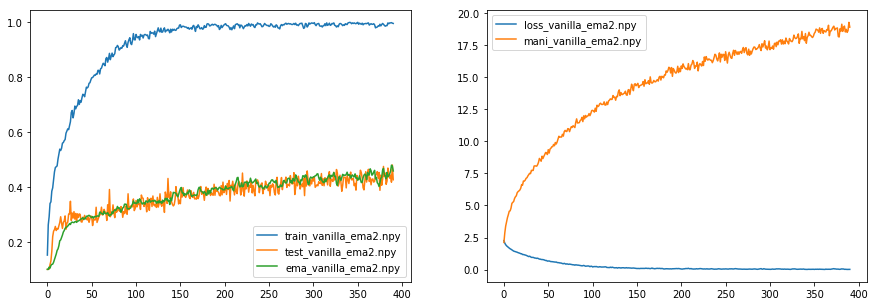

Epoch: 391,global_stp: 7840, xloss: 0.01501, maniloss: 18.91094, train: 99.70%, test: 43.40,test_ma: 46.22%
Epoch: 392,global_stp: 7860, xloss: 0.01341, maniloss: 18.65222, train: 99.90%, test: 47.23,test_ma: 47.13%
Epoch: 393,global_stp: 7880, xloss: 0.01044, maniloss: 18.77178, train: 99.90%, test: 47.20,test_ma: 45.80%
Epoch: 394,global_stp: 7900, xloss: 0.01020, maniloss: 18.84639, train: 100.00%, test: 47.62,test_ma: 45.69%
Epoch: 395,global_stp: 7920, xloss: 0.01548, maniloss: 18.86900, train: 99.50%, test: 43.79,test_ma: 45.74%
Epoch: 396,global_stp: 7940, xloss: 0.02066, maniloss: 19.20535, train: 99.40%, test: 44.79,test_ma: 45.46%
Epoch: 397,global_stp: 7960, xloss: 0.01946, maniloss: 18.66729, train: 99.40%, test: 44.70,test_ma: 47.10%
Epoch: 398,global_stp: 7980, xloss: 0.02857, maniloss: 18.96366, train: 99.20%, test: 45.54,test_ma: 45.52%
Epoch: 399,global_stp: 8000, xloss: 0.04764, maniloss: 18.91980, train: 98.80%, test: 41.54,test_ma: 45.61%
Epoch: 400,global_stp: 8020

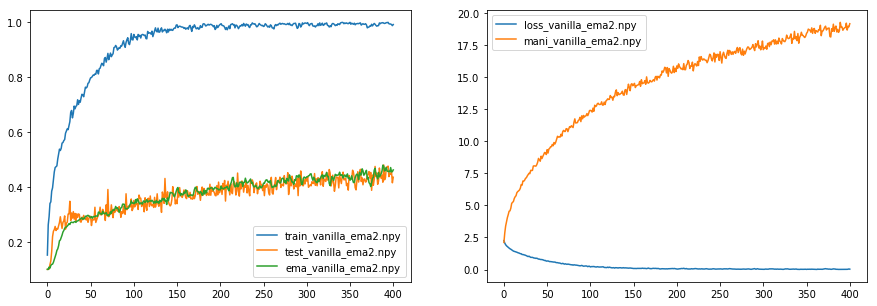

In [24]:
for epoch in tqdm(range(params_dnn['epoch'])):
    inds = rng.permutation(trainx.shape[0])
    trainx = trainx[inds]
    trainy = trainy[inds]
    train_acc=test_acc=train_loss=train_manifold=test_acc_ema=0
    
    for step in range(nr_batch_train):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        xl, _ , acc,ml =  sess.run([xloss,train_op, accuracy,manifold_loss], {inp: trainx[ran_from:ran_to],
                                                                             lbl: trainy[ran_from:ran_to],
                                                                             is_training_pl:False,
                                                                             training_cnn:True})
        train_acc += acc; train_loss += xl; train_manifold += ml
    train_acc /= nr_batch_train; train_loss /= nr_batch_train; train_manifold /= nr_batch_train
    train_array.append(train_acc);loss_array.append(train_loss);manifold_array.append(train_manifold)
    for step in range(nr_batch_test):
        ran_from = step * params_dnn['batch']
        ran_to = (step+1) * params_dnn['batch']
        acc,acc_ema = sess.run([accuracy,accuracy_ema], {inp: testx[ran_from:ran_to],
                                         lbl: testy[ran_from:ran_to],
                                         training_cnn:False})
        test_acc += acc; test_acc_ema += acc_ema
    test_acc /= nr_batch_test; test_acc_ema /=nr_batch_test
    test_array.append(test_acc);test_array_ema.append(test_acc_ema)
    
    print("Epoch: {},global_stp: {}, xloss: {:.5f}, maniloss: {:.5f}, train: {:.2f}%, test: {:.2f},test_ma: {:.2f}%".format(
            epoch, sess.run(global_step),train_loss, train_manifold,train_acc * 100,test_acc*100, test_acc_ema*100))
    
    if  (epoch % 10 == 0):
        np.save(name_experiment,{'train': train_array,
        'test' : test_array,
        'ema' : test_array_ema,
        'loss' : loss_array,
        'mani' : manifold_array,
        'name':name_experiment})
        
        plot_dics([np.load(name_experiment)])
        plt.show()

In [25]:
ls

bac_a_sable.ipynb                    latent_viz.ipynb
cifar_classifier.ipynb               MNIST_data/
cifar-experiments-Copy1.ipynb        mnist_experiments-Copy1.ipynb
cifar-experiments-Copy2.ipynb        mnist_experiments.ipynb
cifar-experiments-Copy3.ipynb        mnist_experiments-reference-Copy1.ipynb
cifar-experiments-Copy4.ipynb        mnist_experiments-reference.ipynb
cifar-experiments-Copy5.ipynb        mnist_model.py
cifar-experiments.ipynb              mnist_neural_net.py
cifar_model.py                       mnsit-net.ipynb
efficient_model_saved/               nn.py
experiments_regularizations_1.ipynb  __pycache__/
experiments_regularizations_2.ipynb  README.md
experiments_regularizations_3.ipynb  regularized-neural-net.ipynb
gamma0.03_epsilon20_ema.npy          ssl_experiments.ipynb
gamma0.04_epsilon25_eta2_ema.npy     utils.py
gamma0.05_epsilon25_eta2_ema.npy     vanilla_ema2.npy
gamma0.07_epsilon25_eta2_ema.npy     vanilla_ema3.npy
gamma0.1_epsilon25_eta2_ema.npy      van